In [5]:
import pandas as pd

# Load the dataset
file_path = 'mixalldata_clean.csv'
df = pd.read_csv(file_path)

# Specify numeric columns
numeric_columns = [
    'sendTime', 'posx', 'posy', 'posz', 'posx_n', 'posy_n', 'posz_n',
    'spdx', 'spdy', 'spdz', 'spdx_n', 'spdy_n', 'spdz_n',
    'aclx', 'acly', 'aclz', 'aclx_n', 'acly_n', 'aclz_n',
    'hedx', 'hedy', 'hedz', 'hedx_n', 'hedy_n', 'hedz_n', 'class'
]
df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce')

# Sort by 'sender' and 'sendTime' for time-sequential ordering within each sender
df = df.sort_values(by=['sender', 'sendTime']).reset_index(drop=True)

# Identify high-frequency senders with more than 200 records
sender_counts = df['sender'].value_counts()
high_freq_senders = sender_counts[sender_counts > 200].index.tolist()

# Filter dataset to keep only records from high-frequency senders
filtered_df = df[df['sender'].isin(high_freq_senders)]

# Ensure each sender in the final dataset has at least 5 occurrences
# Filter to keep only senders with at least 5 records in the dataset
filtered_senders = filtered_df.groupby('sender').filter(lambda x: len(x) >= 5)

# Separate filtered records into misbehavior and normal classes
misbehavior_records = filtered_senders[filtered_senders['class'] != 0]
normal_records = filtered_senders[filtered_senders['class'] == 0]

# Sample 2000 records per misbehavior class, ensuring each sender has at least 5 occurrences
misbehavior_sample = (
    misbehavior_records.groupby('class')
    .apply(lambda x: x.head(2000))
    .reset_index(drop=True)
)

# Calculate the remaining sample size needed from normal records to reach 100,000 total
normal_sample_size = 100000 - len(misbehavior_sample)

# Sample normal records while ensuring each sender occurs at least 5 times
normal_sample = (
    normal_records.groupby('sender')
    .apply(lambda x: x.head(5))  # Take at least 5 records per sender
    .reset_index(drop=True)
)

# If additional normal records are needed, sample from remaining normal records
additional_normal_records_needed = normal_sample_size - len(normal_sample)
if additional_normal_records_needed > 0:
    remaining_normal_sample = (
        normal_records[~normal_records.index.isin(normal_sample.index)]
        .sample(n=additional_normal_records_needed, random_state=42)
    )
    normal_sample = pd.concat([normal_sample, remaining_normal_sample])

# Combine misbehavior and normal samples, and sort by 'sendTime' for a sequential dataset
final_df = pd.concat([normal_sample, misbehavior_sample]).sort_values(by='sendTime').reset_index(drop=True)

# Display final class distribution to verify balance and sender occurrence condition
print("Class distribution in final dataset:")
print(final_df['class'].value_counts())

# Verify each sender appears at least 5 times in the final dataset
sender_occurrences = final_df['sender'].value_counts()
print("All senders have at least 5 occurrences:", (sender_occurrences >= 5).all())

Class distribution in final dataset:
0     62000
18     2000
1      2000
2      2000
3      2000
4      2000
5      2000
6      2000
7      2000
8      2000
19     2000
10     2000
11     2000
12     2000
13     2000
14     2000
15     2000
16     2000
17     2000
9      2000
Name: class, dtype: int64
All senders have at least 5 occurrences: True


In [6]:
# Find all distinct (unique) values in the 'OBU_device_ID' column
distinct_senders = final_df['sender'].unique()

print("Distinct senders:")
print(distinct_senders)
print("Total senders: " + str(len(distinct_senders)))

Distinct senders:
[    93    213    303    471    531    663    735    789    855    915
    921    975   1113   1269   1287   1293   1323   1491   1521   1557
   1671   1731   1815   1851   1869   1875   2049   2055   2115   2139
   2235   2265   2325   2373   2493   2571   2751   2871   3069   3081
   3135   3333   3423   3549   3753   3891   4131   4815   4851   4893
   5031   5235   5613   6243   6375   7203   7209   7323   7623   7905
   8025   8067   8703   8763   8883   9297   9489   9957   9981  10863
  11085  11121  11601  12165  12747  12885  13143  13239  13329  13629
  13947  14439  14445  14451  14559  14577  14763  14895  14961  15003
  15117  15147  15807  15819  15825  16305  16605  16995  17247  17883
  17997  18279  18339  18387  18873  19059  19125  19275  19809  19935
  20175  20253  20337  20589  20625  20655  20703  20925  21501  21921
  21981  22095  22377  22521  22557  23385  24009  24129  24159  24243
  24267  24441  24699  25197  25209  25641  25707  25779  2

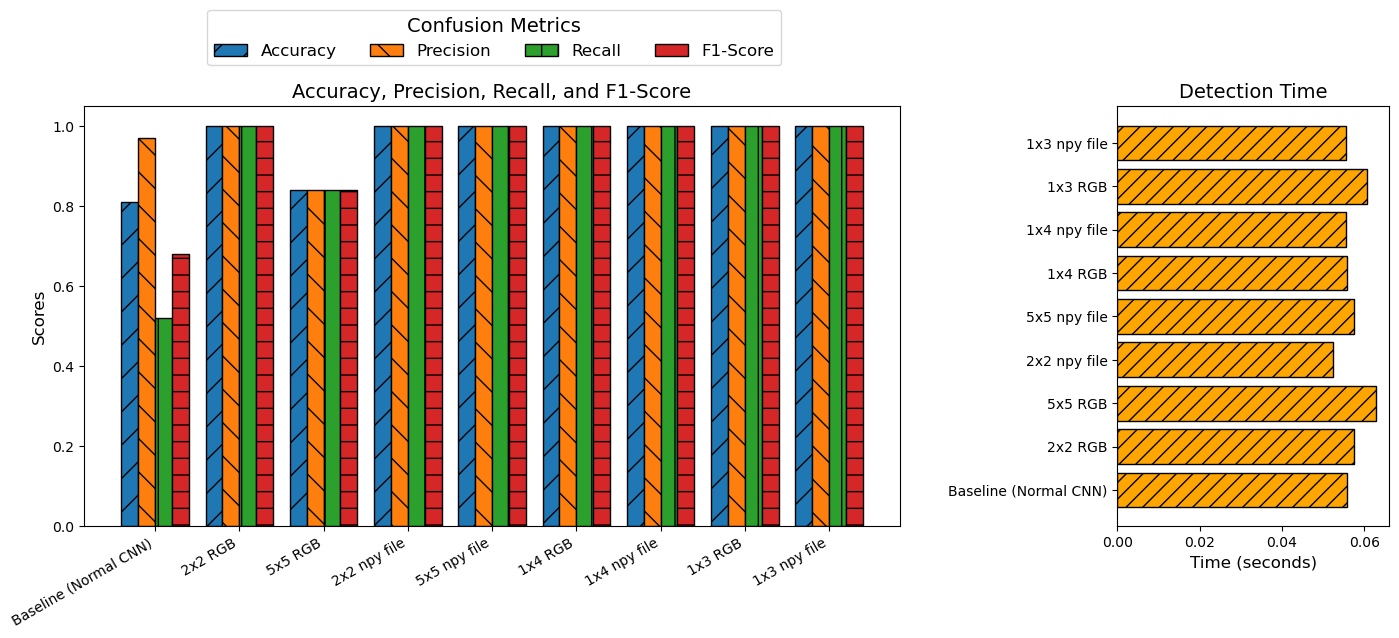

In [1]:
import matplotlib.pyplot as plt
import numpy as np

methods = [
    "Baseline (Normal CNN)", "2x2 RGB", "5x5 RGB",
    "2x2 npy file", "5x5 npy file", "1x4 RGB",
    "1x4 npy file", "1x3 RGB", "1x3 npy file"
]

accuracy = [0.81, 1.00, 0.84, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00]
precision = [0.97, 1.00, 0.84, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00]
recall = [0.52, 1.00, 0.84, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00]
f1_score = [0.68, 1.00, 0.84, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00]
detection_time = [0.055782, 0.057575, 0.062868, 0.052402, 0.057515, 0.055735, 0.055562, 0.060647, 0.055468]

x = np.arange(len(methods))
width = 0.2

hatches = ['/', '\\', '|', '-']

fig, ax = plt.subplots(1, 2, figsize=(15, 7), gridspec_kw={'width_ratios': [3, 1]})

ax[0].bar(x - 1.5 * width, accuracy, width, label="Accuracy", hatch=hatches[0], edgecolor='black')
ax[0].bar(x - 0.5 * width, precision, width, label="Precision", hatch=hatches[1], edgecolor='black')
ax[0].bar(x + 0.5 * width, recall, width, label="Recall", hatch=hatches[2], edgecolor='black')
ax[0].bar(x + 1.5 * width, f1_score, width, label="F1-Score", hatch=hatches[3], edgecolor='black')
ax[0].set_xticks(x)
ax[0].set_xticklabels(methods, rotation=30, ha="right", fontsize=10)
ax[0].set_ylabel("Scores", fontsize=12)
ax[0].set_title("Accuracy, Precision, Recall, and F1-Score", fontsize=14)

ax[1].barh(x, detection_time, color="orange", edgecolor="black", hatch="//", align="center")
ax[1].set_yticks(x)
ax[1].set_yticklabels(methods, fontsize=10)
ax[1].set_xlabel("Time (seconds)", fontsize=12)
ax[1].set_title("Detection Time", fontsize=14)

fig.legend(
    loc="upper right", 
    bbox_to_anchor=(0.55, 1.0), 
    ncol=4, 
    fontsize=12, 
    title="Confusion Metrics", 
    title_fontsize=14
)

plt.subplots_adjust(left=0.08, right=0.95, top=0.85, bottom=0.25, wspace=0.4)

plt.show()

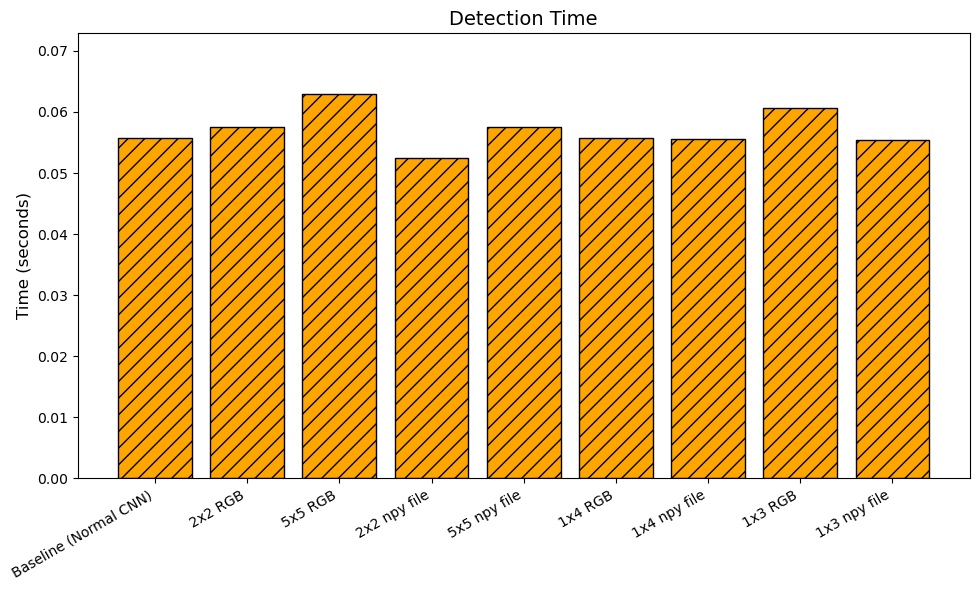

In [2]:
import matplotlib.pyplot as plt
import numpy as np

methods = [
    "Baseline (Normal CNN)", "2x2 RGB", "5x5 RGB",
    "2x2 npy file", "5x5 npy file", "1x4 RGB",
    "1x4 npy file", "1x3 RGB", "1x3 npy file"
]

detection_time = [0.055782, 0.057575, 0.062868, 0.052402, 0.057515, 0.055735, 0.055562, 0.060647, 0.055468]

x = np.arange(len(methods))

fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(x, detection_time, color="orange", edgecolor="black", hatch="//", align="center")
ax.set_xticks(x)
ax.set_xticklabels(methods, rotation=30, ha="right", fontsize=10)
ax.set_ylim(0, max(detection_time) + 0.01)
ax.set_ylabel("Time (seconds)", fontsize=12)
ax.set_title("Detection Time", fontsize=14)

plt.tight_layout()
plt.show()

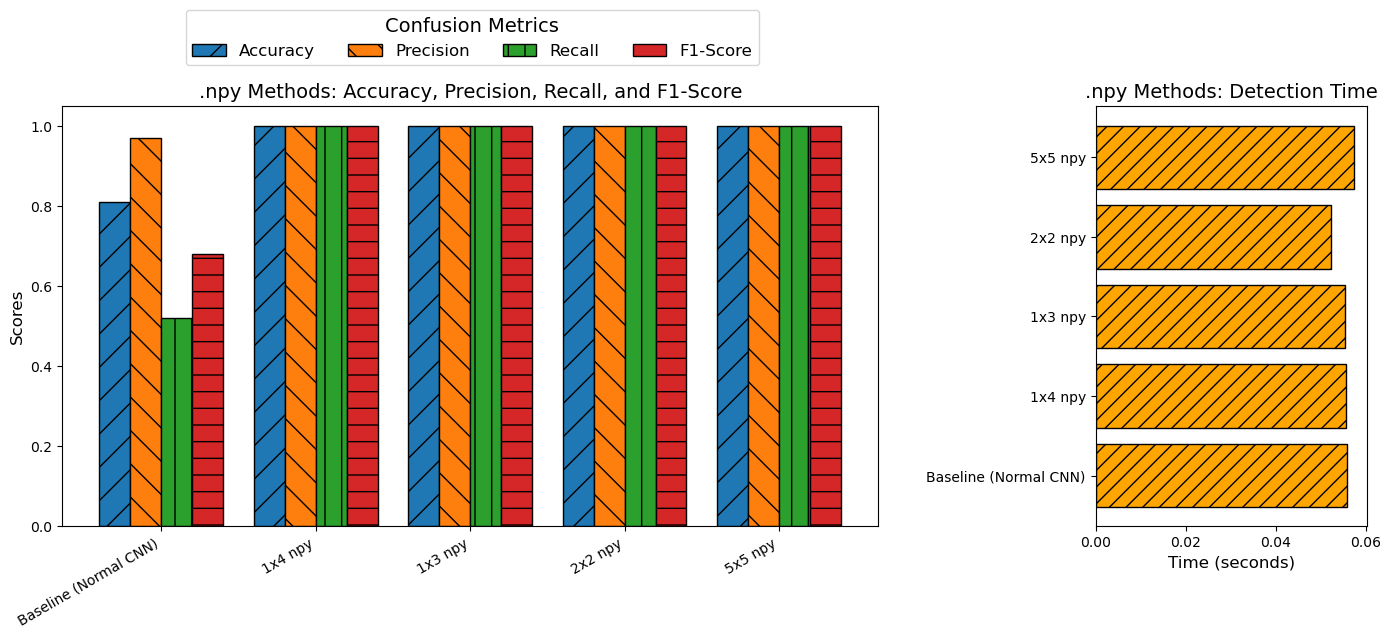

In [53]:
import matplotlib.pyplot as plt
import numpy as np

methods_npy = [
    "Baseline (Normal CNN)",
    "1x4 npy", "1x3 npy",
    "2x2 npy", "5x5 npy",
]

accuracy_npy = [0.81, 1.00, 1.00, 1.00, 1.00]
precision_npy = [0.97, 1.00, 1.00, 1.00, 1.00]
recall_npy = [0.52, 1.00, 1.00, 1.00, 1.00]
f1_score_npy = [0.68, 1.00, 1.00, 1.00, 1.00]
detection_time_npy = [0.055782, 0.055562, 0.055468, 0.052402, 0.057515]

x_npy = np.arange(len(methods_npy))
width = 0.2

hatches = ['/', '\\', '|', '-', '+']

fig, ax = plt.subplots(1, 2, figsize=(15, 7), gridspec_kw={'width_ratios': [3, 1]})

ax[0].bar(x_npy - 1.5 * width, accuracy_npy, width, label="Accuracy", hatch=hatches[0], edgecolor='black')
ax[0].bar(x_npy - 0.5 * width, precision_npy, width, label="Precision", hatch=hatches[1], edgecolor='black')
ax[0].bar(x_npy + 0.5 * width, recall_npy, width, label="Recall", hatch=hatches[2], edgecolor='black')
ax[0].bar(x_npy + 1.5 * width, f1_score_npy, width, label="F1-Score", hatch=hatches[3], edgecolor='black')
ax[0].set_xticks(x_npy)
ax[0].set_xticklabels(methods_npy, rotation=30, ha="right", fontsize=10)
ax[0].set_ylabel("Scores", fontsize=12)
ax[0].set_title(".npy Methods: Accuracy, Precision, Recall, and F1-Score", fontsize=14)

ax[1].barh(x_npy, detection_time_npy, color="orange", edgecolor="black", hatch="//", align="center")
ax[1].set_yticks(x_npy)
ax[1].set_yticklabels(methods_npy, fontsize=10)
ax[1].set_xlabel("Time (seconds)", fontsize=12)
ax[1].set_title(".npy Methods: Detection Time", fontsize=14)

fig.legend(
    loc="upper right", 
    bbox_to_anchor=(0.55, 1.0), 
    ncol=4, 
    fontsize=12, 
    title="Confusion Metrics", 
    title_fontsize=14
)

plt.subplots_adjust(left=0.08, right=0.95, top=0.85, bottom=0.25, wspace=0.4)

plt.show()

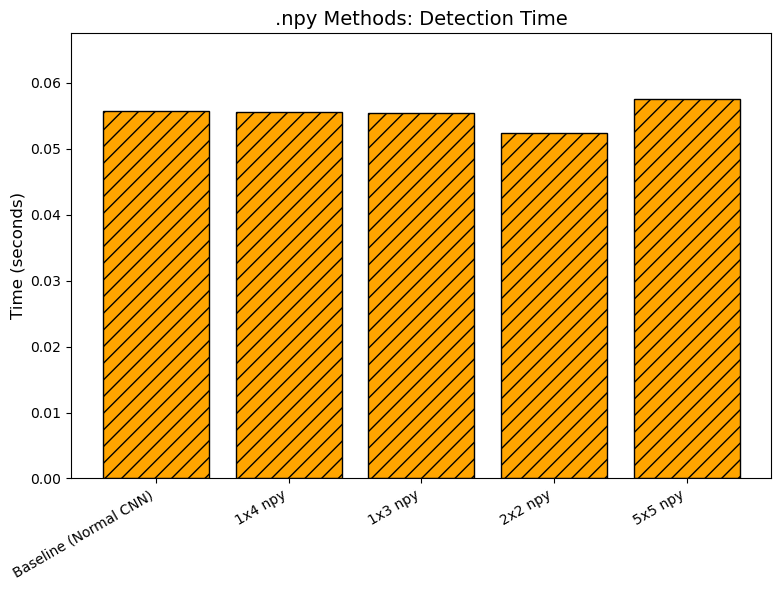

In [54]:
import matplotlib.pyplot as plt
import numpy as np

methods_npy = [
    "Baseline (Normal CNN)",
    "1x4 npy", "1x3 npy",
    "2x2 npy", "5x5 npy",
]

detection_time_npy = [0.055782, 0.055562, 0.055468, 0.052402, 0.057515]

x_npy = np.arange(len(methods_npy))

fig, ax = plt.subplots(figsize=(8, 6))

ax.bar(x_npy, detection_time_npy, color="orange", edgecolor="black", hatch="//", align="center")
ax.set_xticks(x_npy)
ax.set_xticklabels(methods_npy, rotation=30, ha="right", fontsize=10)
ax.set_ylim(0, max(detection_time_npy) + 0.01)
ax.set_ylabel("Time (seconds)", fontsize=12)
ax.set_title(".npy Methods: Detection Time", fontsize=14)

plt.tight_layout()
plt.show()

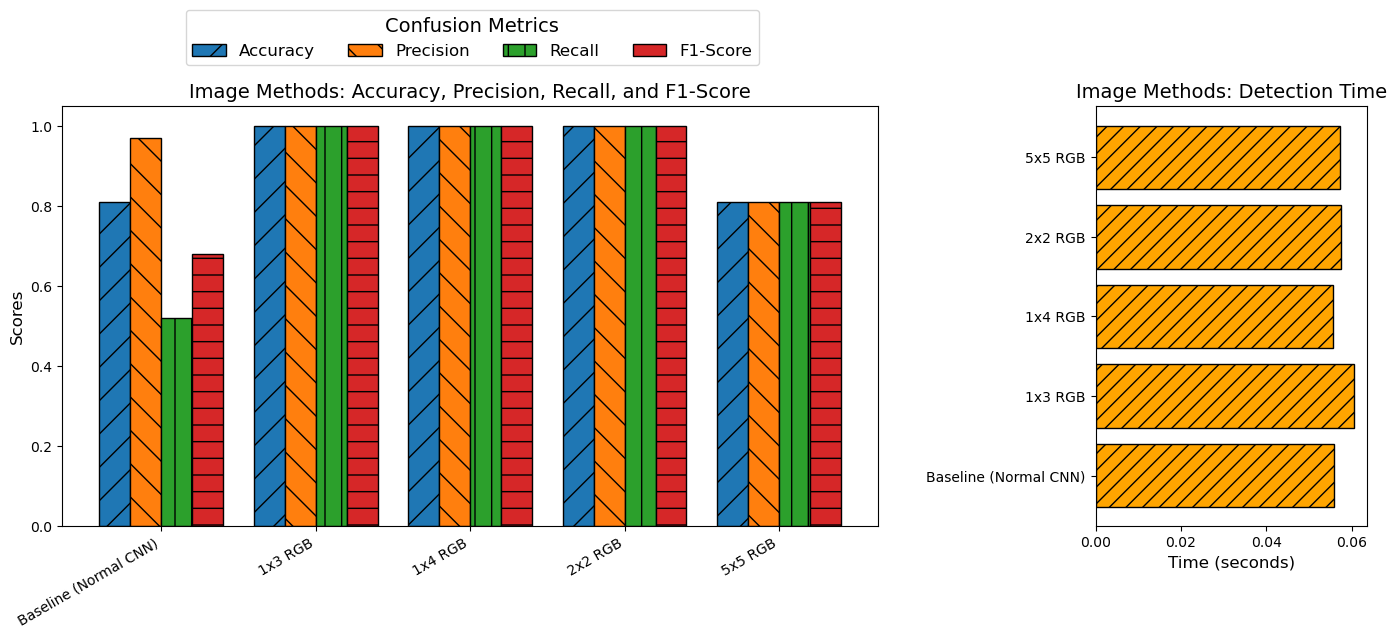

In [5]:
import matplotlib.pyplot as plt
import numpy as np

methods_image = [
    "Baseline (Normal CNN)", 
    "1x3 RGB", "1x4 RGB",
    "2x2 RGB", "5x5 RGB"
]

accuracy_image = [0.81, 1.00, 1.00, 1.00, 0.81]
precision_image = [0.97, 1.00, 1.00, 1.00, 0.81]
recall_image = [0.52, 1.00, 1.00, 1.00, 0.81]
f1_score_image = [0.68, 1.00, 1.00, 1.00, 0.81]
detection_time_image = [0.055782, 0.060647, 0.055735, 0.057575, 0.057283]

x_image = np.arange(len(methods_image))
width = 0.2

hatches = ['/', '\\', '|', '-', '+']

fig, ax = plt.subplots(1, 2, figsize=(15, 7), gridspec_kw={'width_ratios': [3, 1]})

ax[0].bar(x_image - 1.5 * width, accuracy_image, width, label="Accuracy", hatch=hatches[0], edgecolor='black')
ax[0].bar(x_image - 0.5 * width, precision_image, width, label="Precision", hatch=hatches[1], edgecolor='black')
ax[0].bar(x_image + 0.5 * width, recall_image, width, label="Recall", hatch=hatches[2], edgecolor='black')
ax[0].bar(x_image + 1.5 * width, f1_score_image, width, label="F1-Score", hatch=hatches[3], edgecolor='black')
ax[0].set_xticks(x_image)
ax[0].set_xticklabels(methods_image, rotation=30, ha="right", fontsize=10)
ax[0].set_ylabel("Scores", fontsize=12)
ax[0].set_title("Image Methods: Accuracy, Precision, Recall, and F1-Score", fontsize=14)

ax[1].barh(x_image, detection_time_image, color="orange", edgecolor="black", hatch="//", align="center")
ax[1].set_yticks(x_image)
ax[1].set_yticklabels(methods_image, fontsize=10)
ax[1].set_xlabel("Time (seconds)", fontsize=12)
ax[1].set_title("Image Methods: Detection Time", fontsize=14)

fig.legend(
    loc="upper right", 
    bbox_to_anchor=(0.55, 1.0), 
    ncol=4, 
    fontsize=12, 
    title="Confusion Metrics", 
    title_fontsize=14
)

plt.subplots_adjust(left=0.08, right=0.95, top=0.85, bottom=0.25, wspace=0.4)

plt.show()

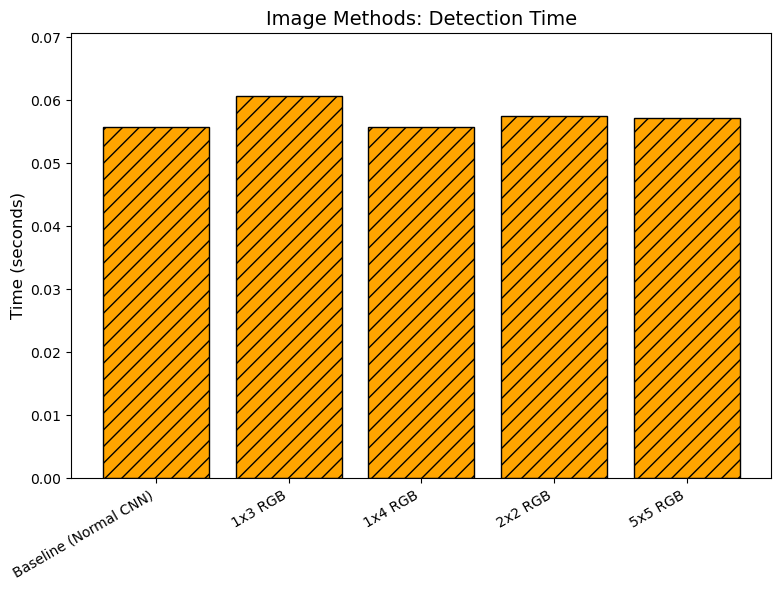

In [6]:
import matplotlib.pyplot as plt
import numpy as np

methods_image = [
    "Baseline (Normal CNN)", 
    "1x3 RGB", "1x4 RGB",
    "2x2 RGB", "5x5 RGB"
]

detection_time_image = [0.055782, 0.060647, 0.055735, 0.057575, 0.057283]

x_image = np.arange(len(methods_image))

fig, ax = plt.subplots(figsize=(8, 6))

ax.bar(x_image, detection_time_image, color="orange", edgecolor="black", hatch="//", align="center")
ax.set_xticks(x_image)
ax.set_xticklabels(methods_image, rotation=30, ha="right", fontsize=10)
ax.set_ylim(0, max(detection_time_image) + 0.01)
ax.set_ylabel("Time (seconds)", fontsize=12)
ax.set_title("Image Methods: Detection Time", fontsize=14)

plt.tight_layout()
plt.show()

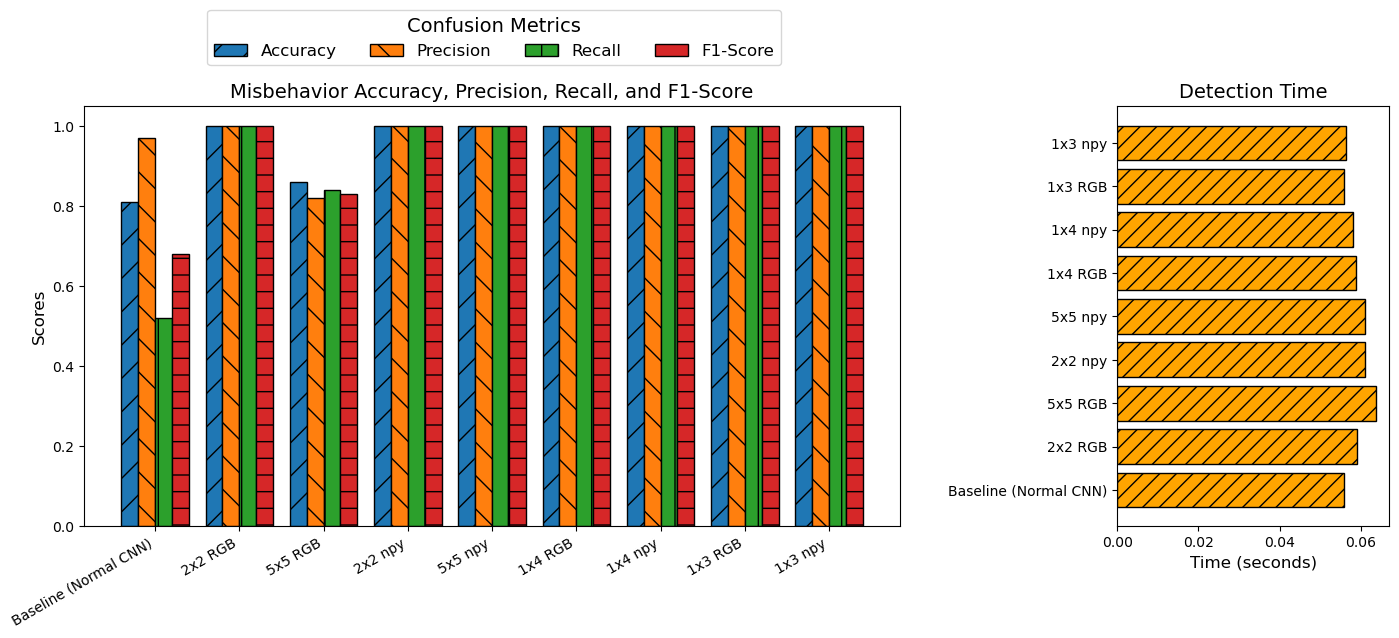

In [55]:
import matplotlib.pyplot as plt
import numpy as np

methods = [
    "Baseline (Normal CNN)",
    "2x2 RGB", "5x5 RGB", "2x2 npy",
    "5x5 npy", "1x4 RGB", "1x4 npy",
    "1x3 RGB", "1x3 npy"
]

accuracy = [0.81, 1.00, 0.86, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00]
precision = [0.97, 1.00, 0.82, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00]
recall = [0.52, 1.00, 0.84, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00]
f1_score = [0.68, 1.00, 0.83, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00]
detection_time = [0.055782, 0.059012, 0.063831, 0.061032, 0.060961, 0.058811, 0.058153, 0.055937, 0.056441]

x = np.arange(len(methods))
width = 0.2

hatches = ['/', '\\', '|', '-']

fig, ax = plt.subplots(1, 2, figsize=(15, 7), gridspec_kw={'width_ratios': [3, 1]})

ax[0].bar(x - 1.5 * width, accuracy, width, label="Accuracy", hatch=hatches[0], edgecolor='black')
ax[0].bar(x - 0.5 * width, precision, width, label="Precision", hatch=hatches[1], edgecolor='black')
ax[0].bar(x + 0.5 * width, recall, width, label="Recall", hatch=hatches[2], edgecolor='black')
ax[0].bar(x + 1.5 * width, f1_score, width, label="F1-Score", hatch=hatches[3], edgecolor='black')
ax[0].set_xticks(x)
ax[0].set_xticklabels(methods, rotation=30, ha="right", fontsize=10)
ax[0].set_ylabel("Scores", fontsize=12)
ax[0].set_title("Misbehavior Accuracy, Precision, Recall, and F1-Score", fontsize=14)

ax[1].barh(x, detection_time, color="orange", edgecolor="black", hatch="//", align="center")
ax[1].set_yticks(x)
ax[1].set_yticklabels(methods, fontsize=10)
ax[1].set_xlabel("Time (seconds)", fontsize=12)
ax[1].set_title("Detection Time", fontsize=14)

fig.legend(
    loc="upper right", 
    bbox_to_anchor=(0.55, 1.0), 
    ncol=4, 
    fontsize=12, 
    title="Confusion Metrics", 
    title_fontsize=14
)

plt.subplots_adjust(left=0.08, right=0.95, top=0.85, bottom=0.25, wspace=0.4)

plt.show()

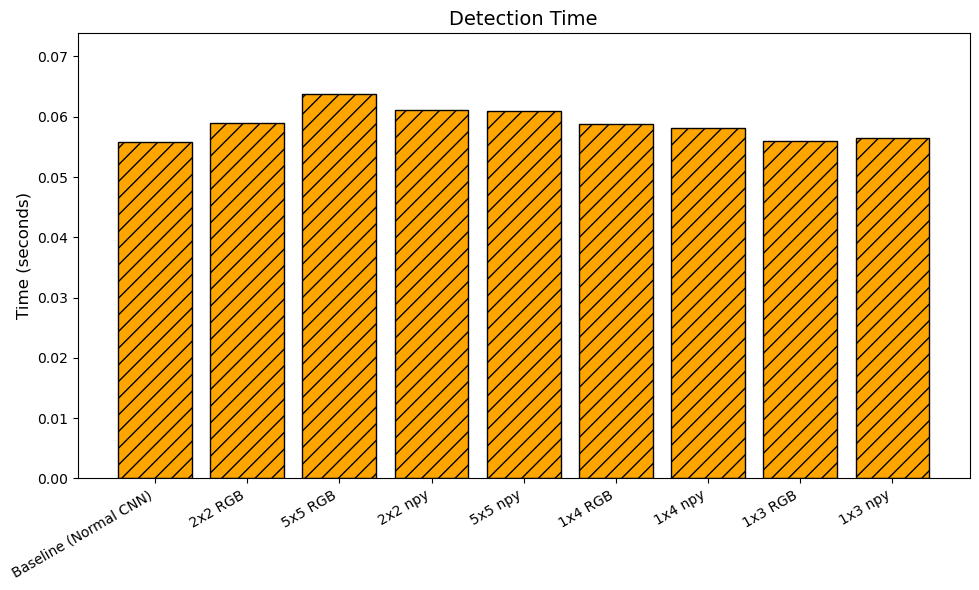

In [56]:
import matplotlib.pyplot as plt
import numpy as np

methods = [
    "Baseline (Normal CNN)",
    "2x2 RGB", "5x5 RGB", "2x2 npy",
    "5x5 npy", "1x4 RGB", "1x4 npy",
    "1x3 RGB", "1x3 npy"
]

detection_time = [0.055782, 0.059012, 0.063831, 0.061032, 0.060961, 0.058811, 0.058153, 0.055937, 0.056441]

x = np.arange(len(methods))

fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(x, detection_time, color="orange", edgecolor="black", hatch="//", align="center")
ax.set_xticks(x)
ax.set_xticklabels(methods, rotation=30, ha="right", fontsize=10)
ax.set_ylim(0, max(detection_time) + 0.01)
ax.set_ylabel("Time (seconds)", fontsize=12)
ax.set_title("Detection Time", fontsize=14)

plt.tight_layout()
plt.show()

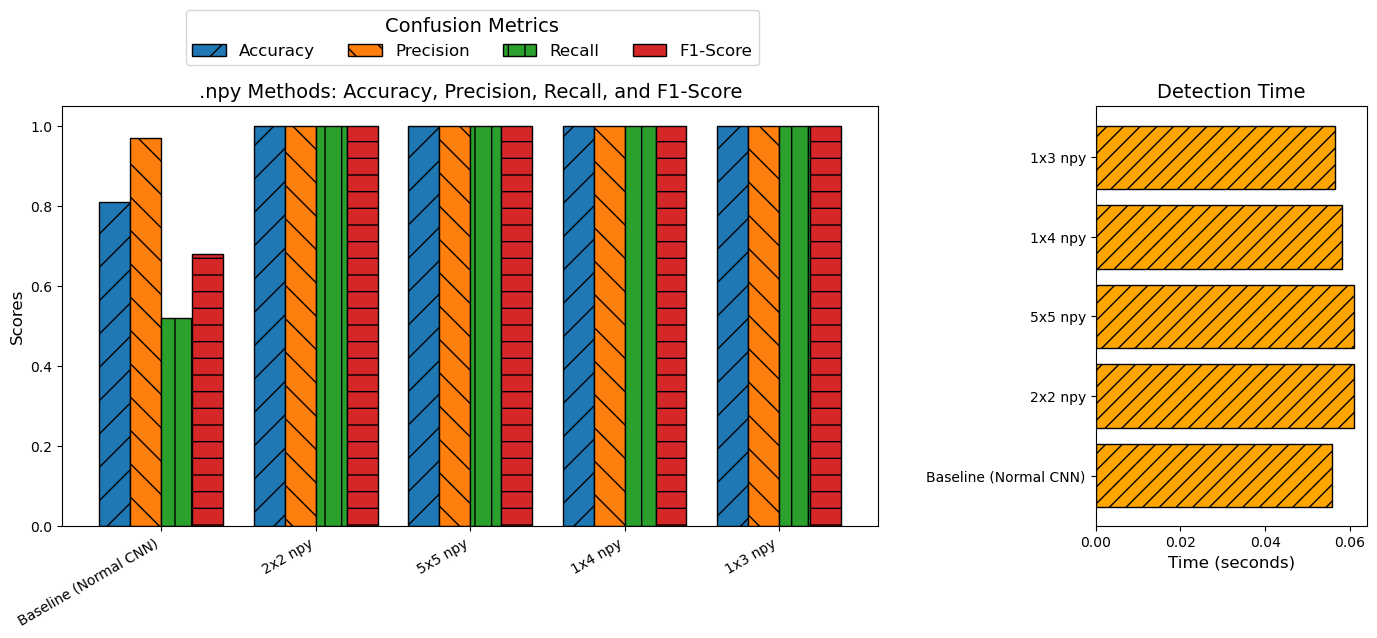

In [57]:
import matplotlib.pyplot as plt
import numpy as np

methods_npy = [
    "Baseline (Normal CNN)",
    "2x2 npy", "5x5 npy", 
    "1x4 npy", "1x3 npy"
]

accuracy_npy = [0.81, 1.00, 1.00, 1.00, 1.00]
precision_npy = [0.97, 1.00, 1.00, 1.00, 1.00]
recall_npy = [0.52, 1.00, 1.00, 1.00, 1.00]
f1_score_npy = [0.68, 1.00, 1.00, 1.00, 1.00]
detection_time_npy = [0.055782, 0.061032, 0.060961, 0.058153, 0.056441]

x_npy = np.arange(len(methods_npy))
width = 0.2

hatches = ['/', '\\', '|', '-']

fig, ax = plt.subplots(1, 2, figsize=(15, 7), gridspec_kw={'width_ratios': [3, 1]})

ax[0].bar(x_npy - 1.5 * width, accuracy_npy, width, label="Accuracy", hatch=hatches[0], edgecolor='black')
ax[0].bar(x_npy - 0.5 * width, precision_npy, width, label="Precision", hatch=hatches[1], edgecolor='black')
ax[0].bar(x_npy + 0.5 * width, recall_npy, width, label="Recall", hatch=hatches[2], edgecolor='black')
ax[0].bar(x_npy + 1.5 * width, f1_score_npy, width, label="F1-Score", hatch=hatches[3], edgecolor='black')
ax[0].set_xticks(x_npy)
ax[0].set_xticklabels(methods_npy, rotation=30, ha="right", fontsize=10)
ax[0].set_ylabel("Scores", fontsize=12)
ax[0].set_title(".npy Methods: Accuracy, Precision, Recall, and F1-Score", fontsize=14)

ax[1].barh(x_npy, detection_time_npy, color="orange", edgecolor="black", hatch="//", align="center")
ax[1].set_yticks(x_npy)
ax[1].set_yticklabels(methods_npy, fontsize=10)
ax[1].set_xlabel("Time (seconds)", fontsize=12)
ax[1].set_title("Detection Time", fontsize=14)

fig.legend(
    loc="upper right", 
    bbox_to_anchor=(0.55, 1.0), 
    ncol=4, 
    fontsize=12, 
    title="Confusion Metrics", 
    title_fontsize=14
)

plt.subplots_adjust(left=0.08, right=0.95, top=0.85, bottom=0.25, wspace=0.4)

plt.show()

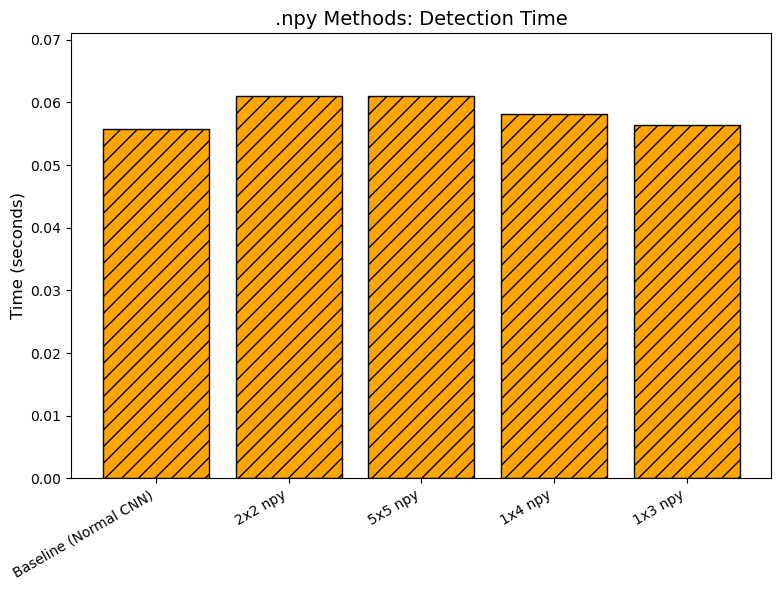

In [58]:
import matplotlib.pyplot as plt
import numpy as np

methods_npy = [
    "Baseline (Normal CNN)",
    "2x2 npy", "5x5 npy", 
    "1x4 npy", "1x3 npy"
]

detection_time_npy = [0.055782, 0.061032, 0.060961, 0.058153, 0.056441]

x_npy = np.arange(len(methods_npy))

fig, ax = plt.subplots(figsize=(8, 6))

ax.bar(x_npy, detection_time_npy, color="orange", edgecolor="black", hatch="//", align="center")
ax.set_xticks(x_npy)
ax.set_xticklabels(methods_npy, rotation=30, ha="right", fontsize=10)
ax.set_ylim(0, max(detection_time_npy) + 0.01)
ax.set_ylabel("Time (seconds)", fontsize=12)
ax.set_title(".npy Methods: Detection Time", fontsize=14)

plt.tight_layout()
plt.show()

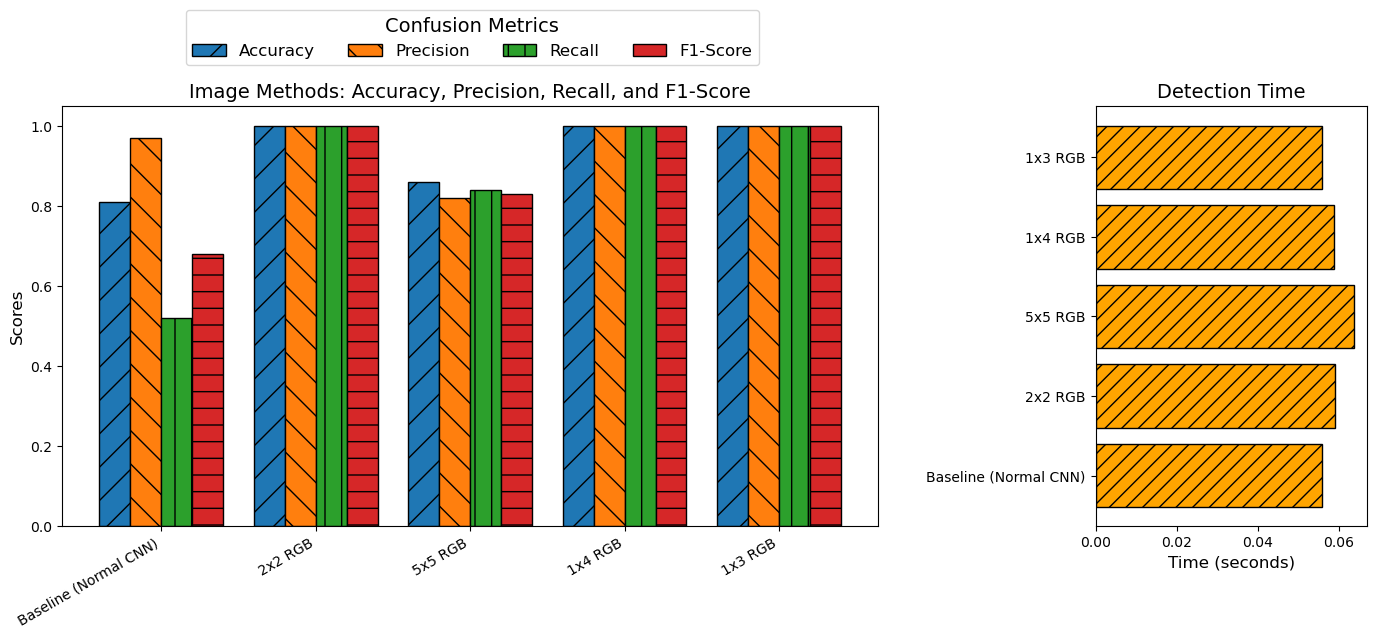

In [14]:
import matplotlib.pyplot as plt
import numpy as np

methods_image = [
    "Baseline (Normal CNN)", 
    "2x2 RGB", "5x5 RGB", 
    "1x4 RGB", "1x3 RGB"
]

accuracy_image = [0.81, 1.00, 0.86, 1.00, 1.00]
precision_image = [0.97, 1.00, 0.82, 1.00, 1.00]
recall_image = [0.52, 1.00, 0.84, 1.00, 1.00]
f1_score_image = [0.68, 1.00, 0.83, 1.00, 1.00]
detection_time_image = [0.055782, 0.059012, 0.063831, 0.058811, 0.055937]

x_image = np.arange(len(methods_image))
width = 0.2

hatches = ['/', '\\', '|', '-']

fig, ax = plt.subplots(1, 2, figsize=(15, 7), gridspec_kw={'width_ratios': [3, 1]})

ax[0].bar(x_image - 1.5 * width, accuracy_image, width, label="Accuracy", hatch=hatches[0], edgecolor='black')
ax[0].bar(x_image - 0.5 * width, precision_image, width, label="Precision", hatch=hatches[1], edgecolor='black')
ax[0].bar(x_image + 0.5 * width, recall_image, width, label="Recall", hatch=hatches[2], edgecolor='black')
ax[0].bar(x_image + 1.5 * width, f1_score_image, width, label="F1-Score", hatch=hatches[3], edgecolor='black')
ax[0].set_xticks(x_image)
ax[0].set_xticklabels(methods_image, rotation=30, ha="right", fontsize=10)
ax[0].set_ylabel("Scores", fontsize=12)
ax[0].set_title("Image Methods: Accuracy, Precision, Recall, and F1-Score", fontsize=14)

ax[1].barh(x_image, detection_time_image, color="orange", edgecolor="black", hatch="//", align="center")
ax[1].set_yticks(x_image)
ax[1].set_yticklabels(methods_image, fontsize=10)
ax[1].set_xlabel("Time (seconds)", fontsize=12)
ax[1].set_title("Detection Time", fontsize=14)

fig.legend(
    loc="upper right", 
    bbox_to_anchor=(0.55, 1.0), 
    ncol=4, 
    fontsize=12, 
    title="Confusion Metrics", 
    title_fontsize=14
)

plt.subplots_adjust(left=0.08, right=0.95, top=0.85, bottom=0.25, wspace=0.4)

plt.show()

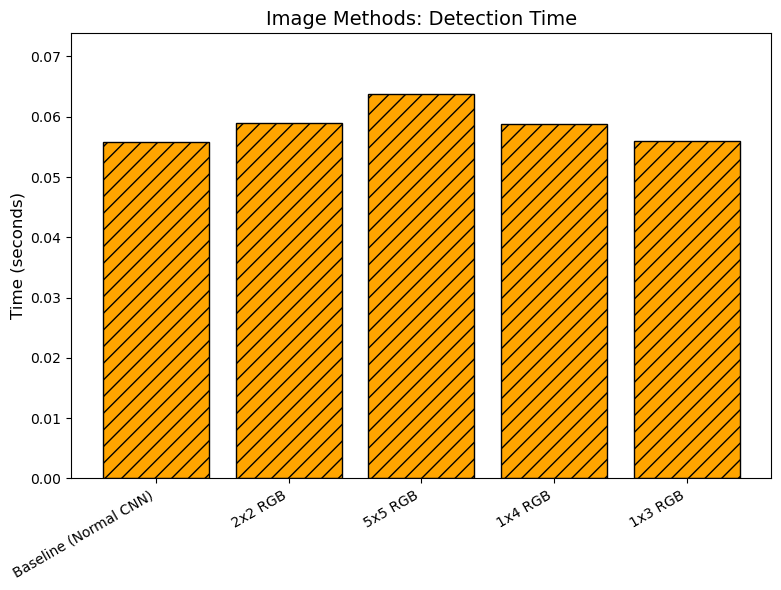

In [15]:
import matplotlib.pyplot as plt
import numpy as np

methods_image = [
    "Baseline (Normal CNN)", 
    "2x2 RGB", "5x5 RGB", 
    "1x4 RGB", "1x3 RGB"
]

detection_time_image = [0.055782, 0.059012, 0.063831, 0.058811, 0.055937]

x_image = np.arange(len(methods_image))

fig, ax = plt.subplots(figsize=(8, 6))

ax.bar(x_image, detection_time_image, color="orange", edgecolor="black", hatch="//", align="center")
ax.set_xticks(x_image)
ax.set_xticklabels(methods_image, rotation=30, ha="right", fontsize=10)
ax.set_ylim(0, max(detection_time_image) + 0.01)
ax.set_ylabel("Time (seconds)", fontsize=12)
ax.set_title("Image Methods: Detection Time", fontsize=14)

plt.tight_layout()
plt.show()

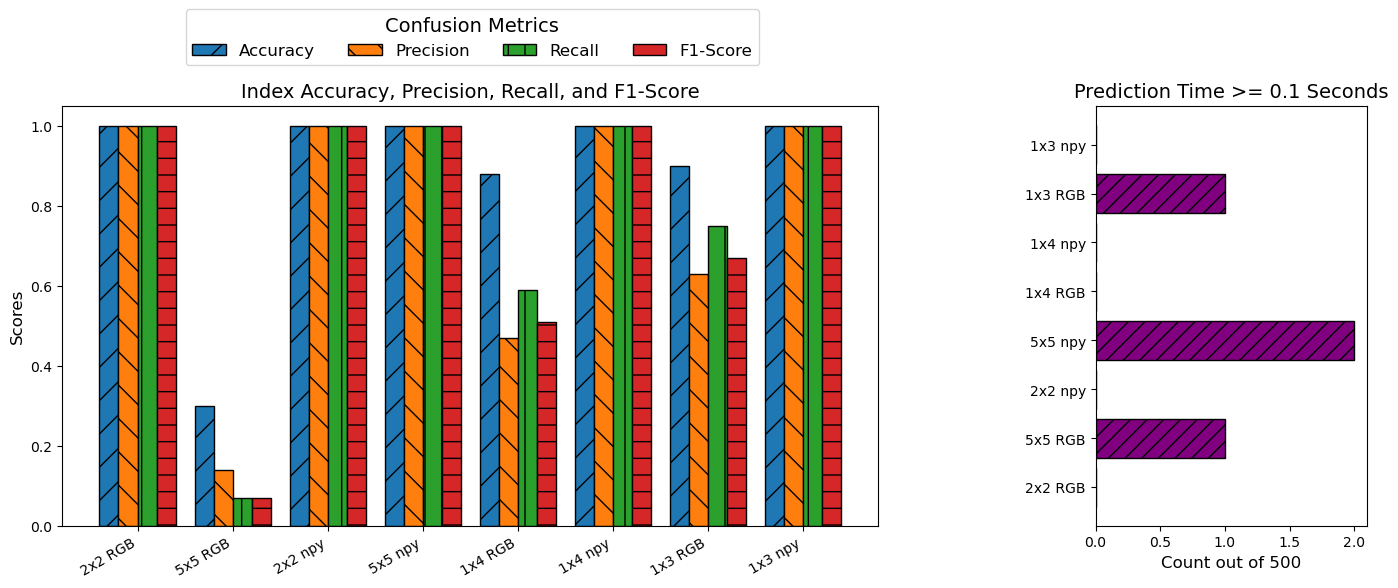

In [59]:
import matplotlib.pyplot as plt
import numpy as np

methods = [
    "2x2 RGB", "5x5 RGB", "2x2 npy",
    "5x5 npy", "1x4 RGB", "1x4 npy",
    "1x3 RGB", "1x3 npy"
]

accuracy = [1.00, 0.30, 1.00, 1.00, 0.88, 1.00, 0.90, 1.00]
precision = [1.00, 0.14, 1.00, 1.00, 0.47, 1.00, 0.63, 1.00]
recall = [1.00, 0.07, 1.00, 1.00, 0.59, 1.00, 0.75, 1.00]
f1_score = [1.00, 0.07, 1.00, 1.00, 0.51, 1.00, 0.67, 1.00]
detection_time = [0, 1, 0, 2, 0, 0, 1, 0]

x = np.arange(len(methods))
width = 0.2

hatches = ['/', '\\', '|', '-']

fig, ax = plt.subplots(1, 2, figsize=(15, 7), gridspec_kw={'width_ratios': [3, 1]})

ax[0].bar(x - 1.5 * width, accuracy, width, label="Accuracy", hatch=hatches[0], edgecolor='black')
ax[0].bar(x - 0.5 * width, precision, width, label="Precision", hatch=hatches[1], edgecolor='black')
ax[0].bar(x + 0.5 * width, recall, width, label="Recall", hatch=hatches[2], edgecolor='black')
ax[0].bar(x + 1.5 * width, f1_score, width, label="F1-Score", hatch=hatches[3], edgecolor='black')
ax[0].set_xticks(x)
ax[0].set_xticklabels(methods, rotation=30, ha="right", fontsize=10)
ax[0].set_ylabel("Scores", fontsize=12)
ax[0].set_title("Index Accuracy, Precision, Recall, and F1-Score", fontsize=14)

ax[1].barh(x, detection_time, color="purple", edgecolor="black", hatch="//", align="center")
ax[1].set_yticks(x)
ax[1].set_yticklabels(methods, fontsize=10)
ax[1].set_xlabel("Count out of 500", fontsize=12)
ax[1].set_title("Prediction Time >= 0.1 Seconds", fontsize=14)

fig.legend(
    loc="upper right", 
    bbox_to_anchor=(0.55, 1.0), 
    ncol=4, 
    fontsize=12, 
    title="Confusion Metrics", 
    title_fontsize=14
)

plt.subplots_adjust(left=0.08, right=0.95, top=0.85, bottom=0.25, wspace=0.4)

plt.show()

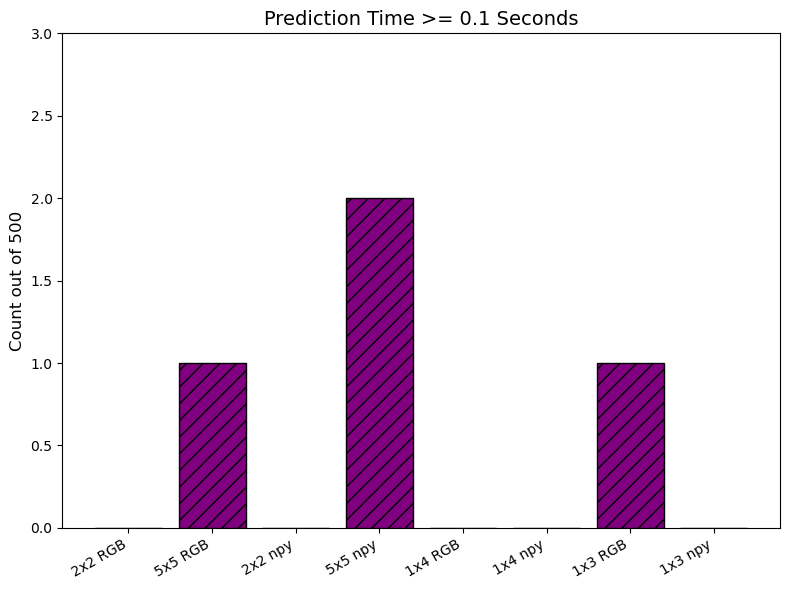

In [60]:
import matplotlib.pyplot as plt
import numpy as np

methods = [
    "2x2 RGB", "5x5 RGB", "2x2 npy",
    "5x5 npy", "1x4 RGB", "1x4 npy",
    "1x3 RGB", "1x3 npy"
]

detection_time = [0, 1, 0, 2, 0, 0, 1, 0]

x = np.arange(len(methods))

fig, ax = plt.subplots(figsize=(8, 6))

ax.bar(x, detection_time, color="purple", edgecolor="black", hatch="//", align="center")
ax.set_xticks(x)
ax.set_xticklabels(methods, rotation=30, ha="right", fontsize=10)
ax.set_ylim(0, max(detection_time) + 1)
ax.set_ylabel("Count out of 500", fontsize=12)
ax.set_title("Prediction Time >= 0.1 Seconds", fontsize=14)

plt.tight_layout()
plt.show()

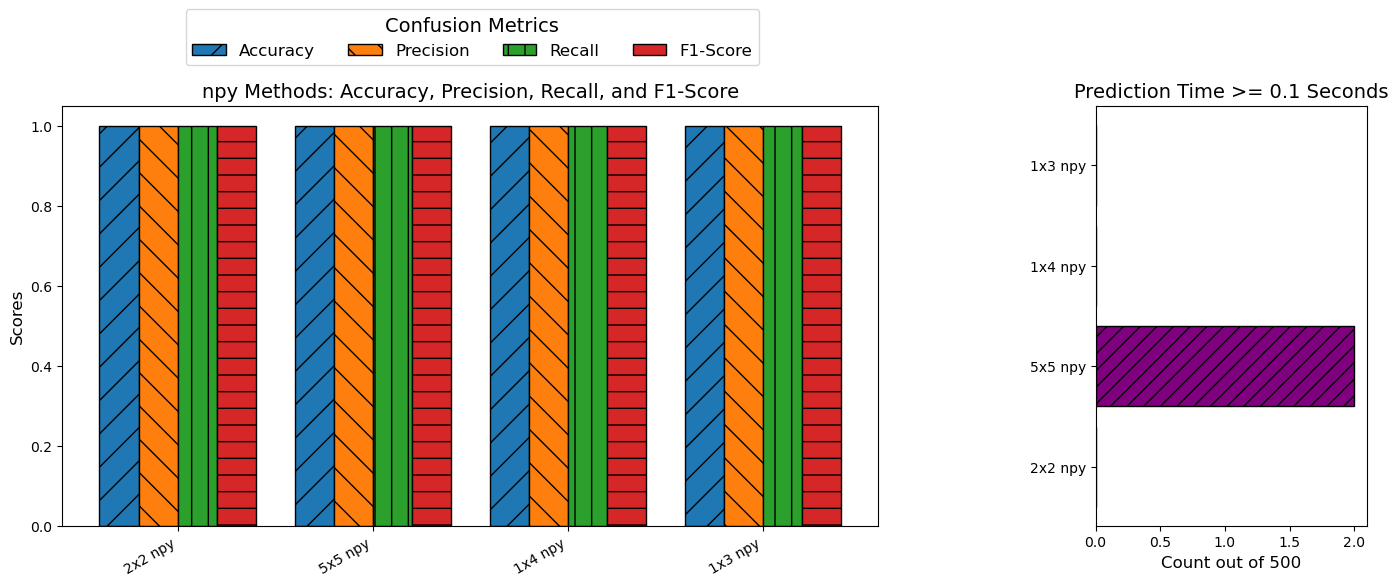

In [61]:
import matplotlib.pyplot as plt
import numpy as np

methods_npy = [
    "2x2 npy", "5x5 npy", "1x4 npy", "1x3 npy"
]

accuracy_npy = [1.00, 1.00, 1.00, 1.00]
precision_npy = [1.00, 1.00, 1.00, 1.00]
recall_npy = [1.00, 1.00, 1.00, 1.00]
f1_score_npy = [1.00, 1.00, 1.00, 1.00]
detection_time_npy = [0, 2, 0, 0]

x_npy = np.arange(len(methods_npy))
width = 0.2

hatches = ['/', '\\', '|', '-']

fig, ax = plt.subplots(1, 2, figsize=(15, 7), gridspec_kw={'width_ratios': [3, 1]})

ax[0].bar(x_npy - 1.5 * width, accuracy_npy, width, label="Accuracy", hatch=hatches[0], edgecolor='black')
ax[0].bar(x_npy - 0.5 * width, precision_npy, width, label="Precision", hatch=hatches[1], edgecolor='black')
ax[0].bar(x_npy + 0.5 * width, recall_npy, width, label="Recall", hatch=hatches[2], edgecolor='black')
ax[0].bar(x_npy + 1.5 * width, f1_score_npy, width, label="F1-Score", hatch=hatches[3], edgecolor='black')
ax[0].set_xticks(x_npy)
ax[0].set_xticklabels(methods_npy, rotation=30, ha="right", fontsize=10)
ax[0].set_ylabel("Scores", fontsize=12)
ax[0].set_title("npy Methods: Accuracy, Precision, Recall, and F1-Score", fontsize=14)

ax[1].barh(x_npy, detection_time_npy, color="purple", edgecolor="black", hatch="//", align="center")
ax[1].set_yticks(x_npy)
ax[1].set_yticklabels(methods_npy, fontsize=10)
ax[1].set_xlabel("Count out of 500", fontsize=12)
ax[1].set_title("Prediction Time >= 0.1 Seconds", fontsize=14)

fig.legend(
    loc="upper right", 
    bbox_to_anchor=(0.55, 1.0), 
    ncol=4, 
    fontsize=12, 
    title="Confusion Metrics", 
    title_fontsize=14
)

plt.subplots_adjust(left=0.08, right=0.95, top=0.85, bottom=0.25, wspace=0.4)

plt.show()

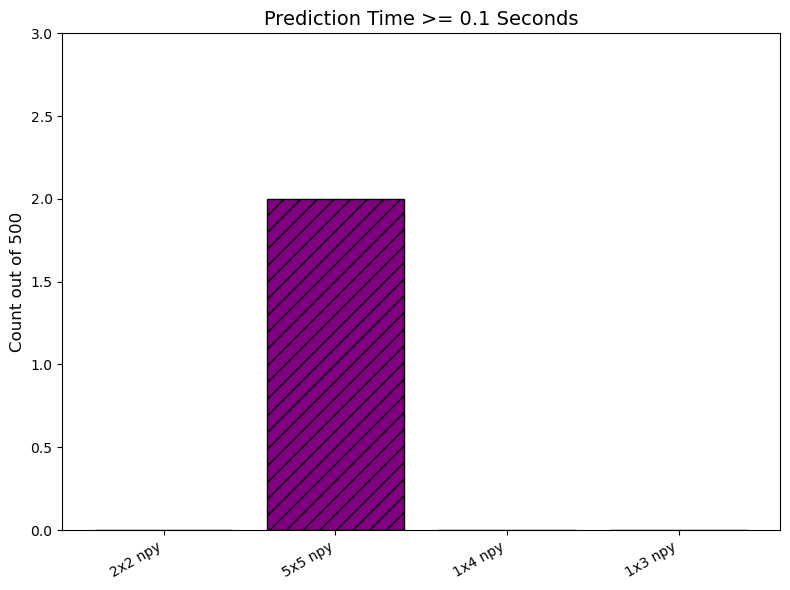

In [62]:
import matplotlib.pyplot as plt
import numpy as np

methods_npy = [
    "2x2 npy", "5x5 npy", 
    "1x4 npy", "1x3 npy"
]

detection_time_npy = [0, 2, 0, 0]

x_npy = np.arange(len(methods_npy))

fig, ax = plt.subplots(figsize=(8, 6))

ax.bar(x_npy, detection_time_npy, color="purple", edgecolor="black", hatch="//", align="center")
ax.set_xticks(x_npy)
ax.set_xticklabels(methods_npy, rotation=30, ha="right", fontsize=10)
ax.set_ylim(0, max(detection_time_npy) + 1)
ax.set_ylabel("Count out of 500", fontsize=12)
ax.set_title("Prediction Time >= 0.1 Seconds", fontsize=14)

plt.tight_layout()
plt.show()

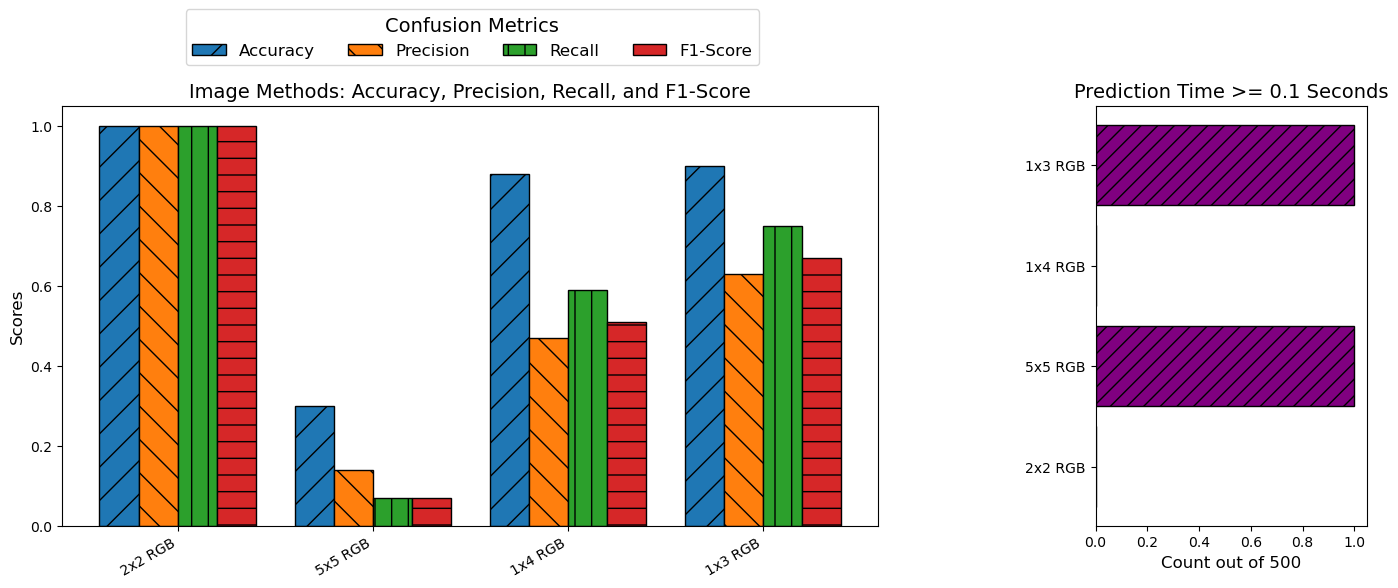

In [20]:
methods_image = [
    "2x2 RGB", "5x5 RGB", "1x4 RGB", "1x3 RGB"
]

accuracy_image = [1.00, 0.30, 0.88, 0.90]
precision_image = [1.00, 0.14, 0.47, 0.63]
recall_image = [1.00, 0.07, 0.59, 0.75]
f1_score_image = [1.00, 0.07, 0.51, 0.67]
detection_time_image = [0, 1, 0, 1]

x_image = np.arange(len(methods_image))

fig, ax = plt.subplots(1, 2, figsize=(15, 7), gridspec_kw={'width_ratios': [3, 1]})

ax[0].bar(x_image - 1.5 * width, accuracy_image, width, label="Accuracy", hatch=hatches[0], edgecolor='black')
ax[0].bar(x_image - 0.5 * width, precision_image, width, label="Precision", hatch=hatches[1], edgecolor='black')
ax[0].bar(x_image + 0.5 * width, recall_image, width, label="Recall", hatch=hatches[2], edgecolor='black')
ax[0].bar(x_image + 1.5 * width, f1_score_image, width, label="F1-Score", hatch=hatches[3], edgecolor='black')
ax[0].set_xticks(x_image)
ax[0].set_xticklabels(methods_image, rotation=30, ha="right", fontsize=10)
ax[0].set_ylabel("Scores", fontsize=12)
ax[0].set_title("Image Methods: Accuracy, Precision, Recall, and F1-Score", fontsize=14)

ax[1].barh(x_image, detection_time_image, color="purple", edgecolor="black", hatch="//", align="center")
ax[1].set_yticks(x_image)
ax[1].set_yticklabels(methods_image, fontsize=10)
ax[1].set_xlabel("Count out of 500", fontsize=12)
ax[1].set_title("Prediction Time >= 0.1 Seconds", fontsize=14)

fig.legend(
    loc="upper right", 
    bbox_to_anchor=(0.55, 1.0), 
    ncol=4, 
    fontsize=12, 
    title="Confusion Metrics", 
    title_fontsize=14
)

plt.subplots_adjust(left=0.08, right=0.95, top=0.85, bottom=0.25, wspace=0.4)

plt.show()

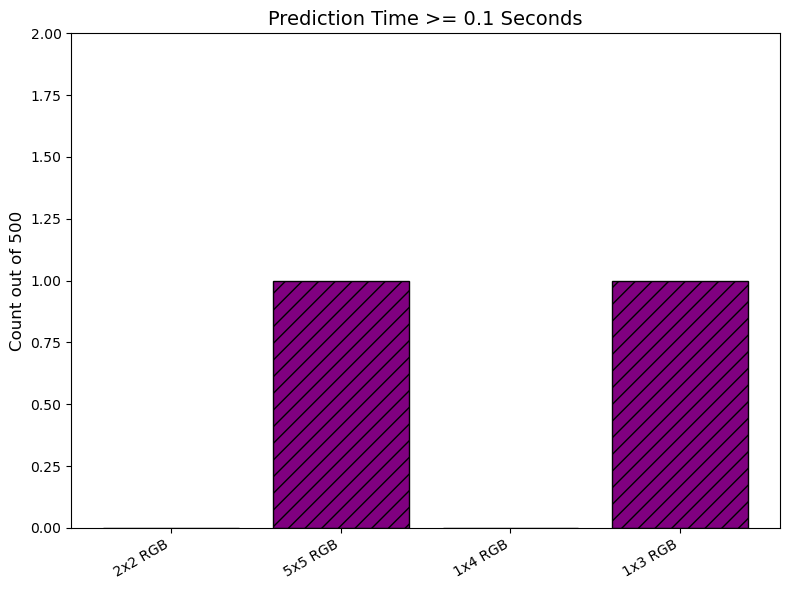

In [21]:
import matplotlib.pyplot as plt
import numpy as np

methods_image = [
    "2x2 RGB", "5x5 RGB", 
    "1x4 RGB", "1x3 RGB"
]

detection_time_image = [0, 1, 0, 1]

x_image = np.arange(len(methods_image))

fig, ax = plt.subplots(figsize=(8, 6))

ax.bar(x_image, detection_time_image, color="purple", edgecolor="black", hatch="//", align="center")
ax.set_xticks(x_image)
ax.set_xticklabels(methods_image, rotation=30, ha="right", fontsize=10)
ax.set_ylim(0, max(detection_time_image) + 1)
ax.set_ylabel("Count out of 500", fontsize=12)
ax.set_title("Prediction Time >= 0.1 Seconds", fontsize=14)

plt.tight_layout()
plt.show()

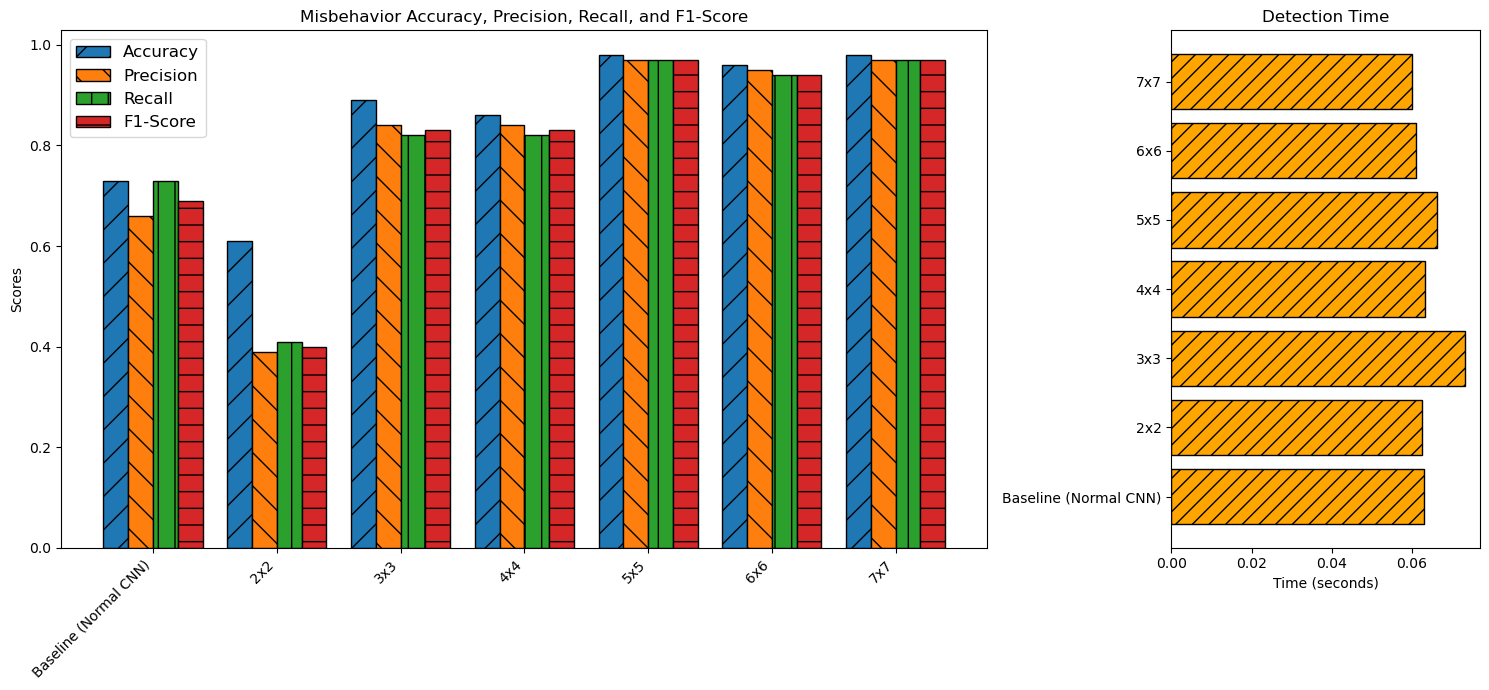

In [23]:
import matplotlib.pyplot as plt
import numpy as np

methods = [
    "Baseline (Normal CNN)",
    "2x2", 
    "3x3", 
    "4x4", 
    "5x5", 
    "6x6", 
    "7x7"
]

accuracy = [0.73, 0.61, 0.89, 0.86, 0.98, 0.96, 0.98]
precision = [0.66, 0.39, 0.84, 0.84, 0.97, 0.95, 0.97]
recall = [0.73, 0.41, 0.82, 0.82, 0.97, 0.94, 0.97]
f1_score = [0.69, 0.40, 0.83, 0.83, 0.97, 0.94, 0.97]
detection_time = [0.063013, 0.062489, 0.073272, 0.063254, 0.066182, 0.060963, 0.059908]

x = np.arange(len(methods))
width = 0.2

hatches = ['/', '\\', '|', '-']

fig, ax = plt.subplots(1, 2, figsize=(15, 7), gridspec_kw={'width_ratios': [3, 1]})

bars1 = ax[0].bar(x - 1.5 * width, accuracy, width, label="Accuracy", hatch=hatches[0], edgecolor='black')
bars2 = ax[0].bar(x - 0.5 * width, precision, width, label="Precision", hatch=hatches[1], edgecolor='black')
bars3 = ax[0].bar(x + 0.5 * width, recall, width, label="Recall", hatch=hatches[2], edgecolor='black')
bars4 = ax[0].bar(x + 1.5 * width, f1_score, width, label="F1-Score", hatch=hatches[3], edgecolor='black')

ax[0].set_xticks(x)
ax[0].set_xticklabels(methods, rotation=45, ha="right")
ax[0].set_ylabel("Scores")
ax[0].set_title("Misbehavior Accuracy, Precision, Recall, and F1-Score")
ax[0].legend(fontsize=12)

ax[1].barh(x, detection_time, color="orange", edgecolor="black", hatch="//", align="center")
ax[1].set_yticks(x)
ax[1].set_yticklabels(methods)
ax[1].set_xlabel("Time (seconds)")
ax[1].set_title("Detection Time")

plt.tight_layout()
plt.show()

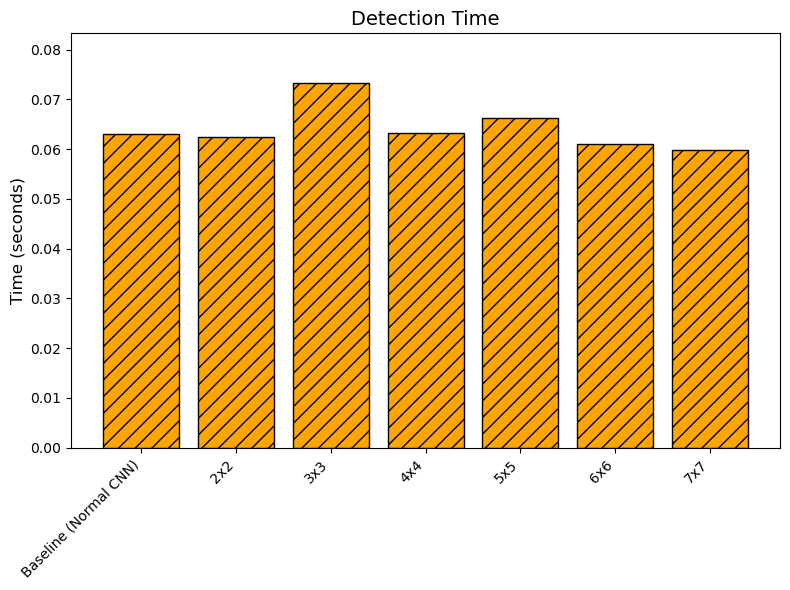

In [24]:
import matplotlib.pyplot as plt
import numpy as np

methods = [
    "Baseline (Normal CNN)",
    "2x2", 
    "3x3", 
    "4x4", 
    "5x5", 
    "6x6", 
    "7x7"
]

detection_time = [0.063013, 0.062489, 0.073272, 0.063254, 0.066182, 0.060963, 0.059908]

x = np.arange(len(methods))

fig, ax = plt.subplots(figsize=(8, 6))

ax.bar(x, detection_time, color="orange", edgecolor="black", hatch="//", align="center")
ax.set_xticks(x)
ax.set_xticklabels(methods, rotation=45, ha="right", fontsize=10)
ax.set_ylim(0, max(detection_time) + 0.01)
ax.set_ylabel("Time (seconds)", fontsize=12)
ax.set_title("Detection Time", fontsize=14)

plt.tight_layout()
plt.show()

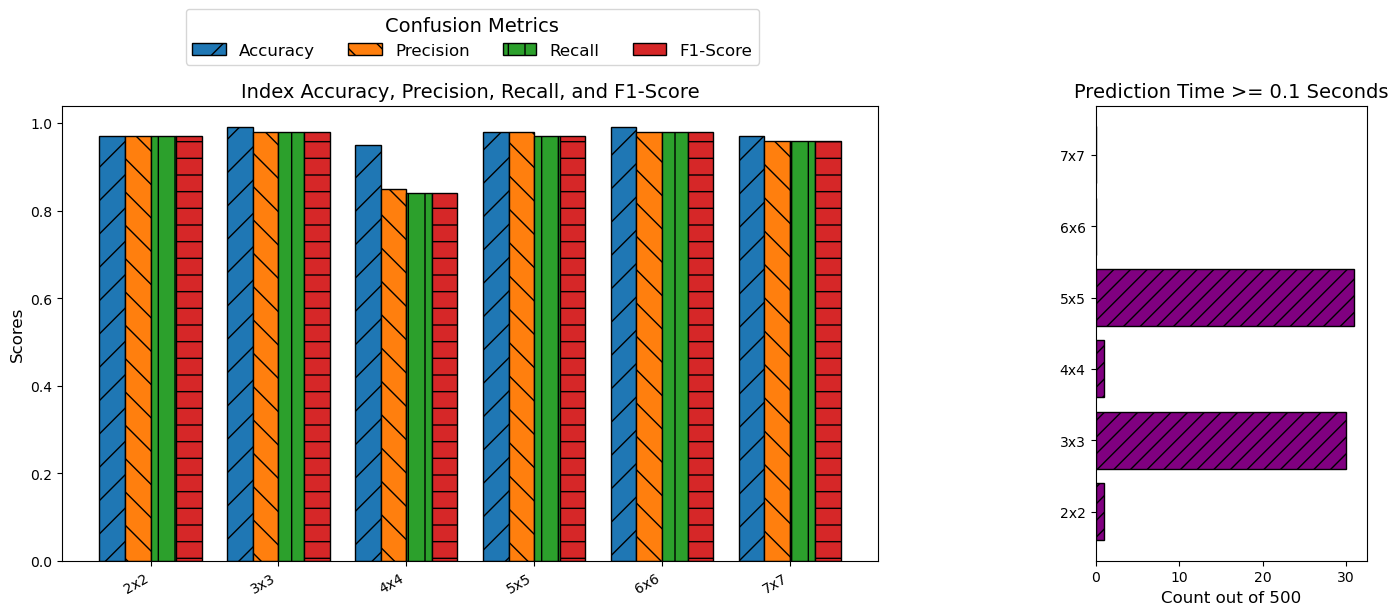

In [66]:
import matplotlib.pyplot as plt
import numpy as np

methods_selected = [
    "2x2", 
    "3x3", 
    "4x4", 
    "5x5", 
    "6x6", 
    "7x7"
]

accuracy_selected = [0.97, 0.99, 0.95, 0.98, 0.99, 0.97]
precision_selected = [0.97, 0.98, 0.85, 0.98, 0.98, 0.96]
recall_selected = [0.97, 0.98, 0.84, 0.97, 0.98, 0.96]
f1_score_selected = [0.97, 0.98, 0.84, 0.97, 0.98, 0.96]
prediction_time_over_0_1_selected = [1, 30, 1, 31, 0, 0]  # Out of 500

x_selected = np.arange(len(methods_selected))
width = 0.2

hatches = ['/', '\\', '|', '-']

fig, ax = plt.subplots(1, 2, figsize=(15, 7), gridspec_kw={'width_ratios': [3, 1]})

ax[0].bar(x_selected - 1.5 * width, accuracy_selected, width, label="Accuracy", hatch=hatches[0], edgecolor='black')
ax[0].bar(x_selected - 0.5 * width, precision_selected, width, label="Precision", hatch=hatches[1], edgecolor='black')
ax[0].bar(x_selected + 0.5 * width, recall_selected, width, label="Recall", hatch=hatches[2], edgecolor='black')
ax[0].bar(x_selected + 1.5 * width, f1_score_selected, width, label="F1-Score", hatch=hatches[3], edgecolor='black')
ax[0].set_xticks(x_selected)
ax[0].set_xticklabels(methods_selected, rotation=30, ha="right", fontsize=10)
ax[0].set_ylabel("Scores", fontsize=12)
ax[0].set_title("Index Accuracy, Precision, Recall, and F1-Score", fontsize=14)

ax[1].barh(x_selected, prediction_time_over_0_1_selected, color="purple", edgecolor="black", hatch="//", align="center")
ax[1].set_yticks(x_selected)
ax[1].set_yticklabels(methods_selected, fontsize=10)
ax[1].set_xlabel("Count out of 500", fontsize=12)
ax[1].set_title("Prediction Time >= 0.1 Seconds", fontsize=14)

fig.legend(
    loc="upper right", 
    bbox_to_anchor=(0.55, 1.0), 
    ncol=4, 
    fontsize=12, 
    title="Confusion Metrics", 
    title_fontsize=14
)

plt.subplots_adjust(left=0.08, right=0.95, top=0.85, bottom=0.2, wspace=0.4)

plt.show()

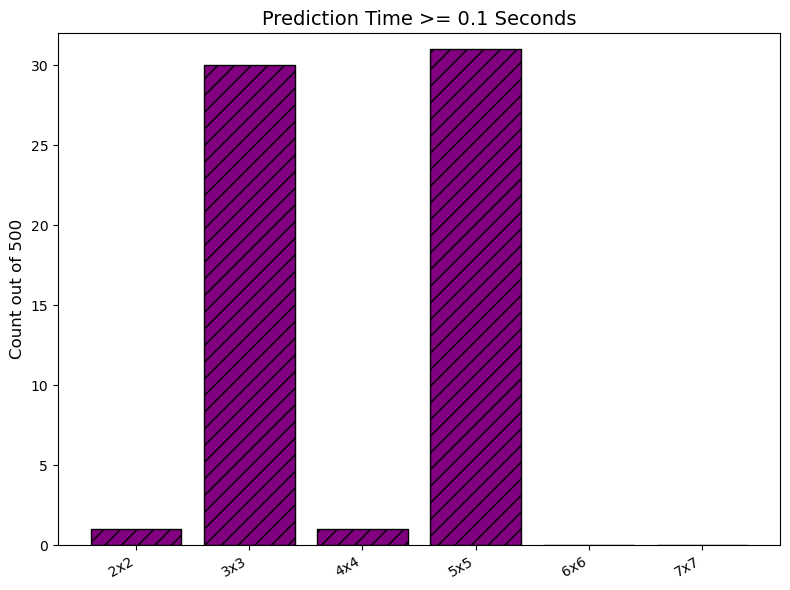

In [26]:
import matplotlib.pyplot as plt
import numpy as np

methods_selected = [
    "2x2", 
    "3x3", 
    "4x4", 
    "5x5", 
    "6x6", 
    "7x7"
]

prediction_time_over_0_1_selected = [1, 30, 1, 31, 0, 0]

x_selected = np.arange(len(methods_selected))

fig, ax = plt.subplots(figsize=(8, 6))

ax.bar(x_selected, prediction_time_over_0_1_selected, color="purple", edgecolor="black", hatch="//", align="center")
ax.set_xticks(x_selected)
ax.set_xticklabels(methods_selected, rotation=30, ha="right", fontsize=10)
ax.set_ylim(0, max(prediction_time_over_0_1_selected) + 1)
ax.set_ylabel("Count out of 500", fontsize=12)
ax.set_title("Prediction Time >= 0.1 Seconds", fontsize=14)

plt.tight_layout()
plt.show()

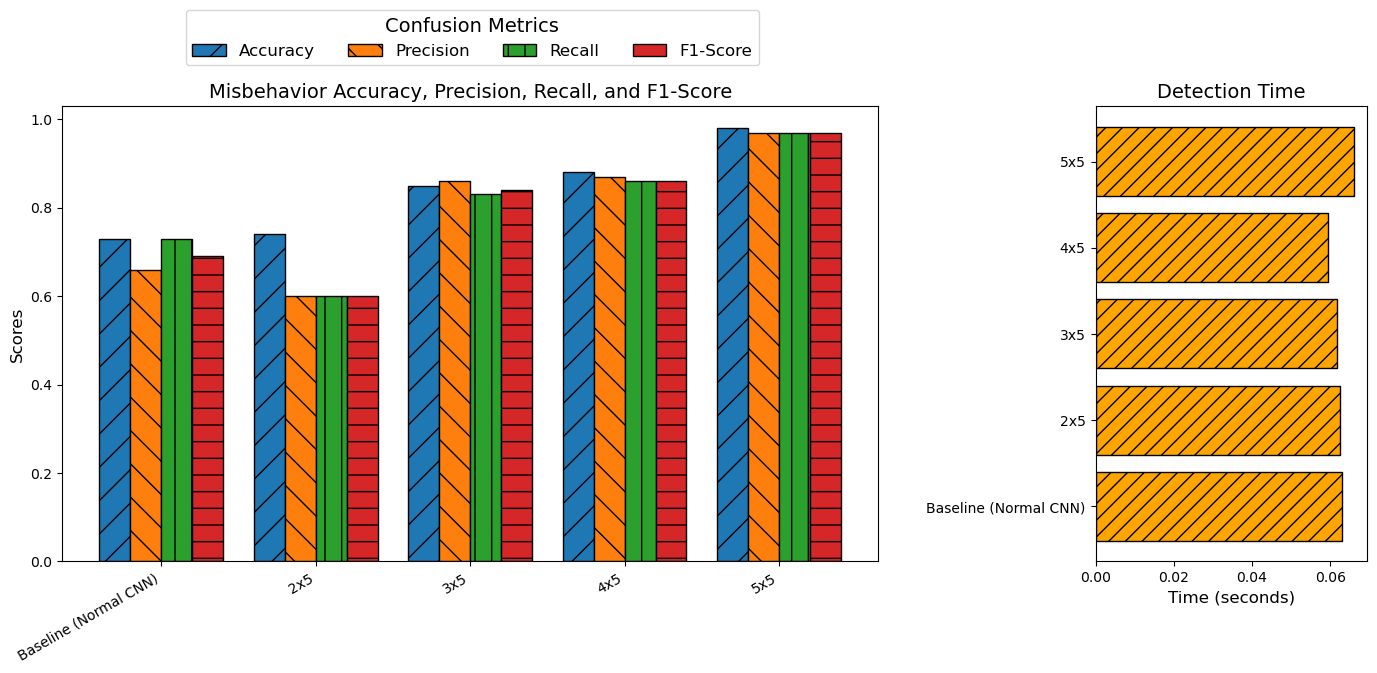

In [65]:
import matplotlib.pyplot as plt
import numpy as np

methods_with_baseline = [
    "Baseline (Normal CNN)", 
    "2x5", 
    "3x5", 
    "4x5", 
    "5x5"
]

accuracy_with_baseline = [0.73, 0.74, 0.85, 0.88, 0.98]
precision_with_baseline = [0.66, 0.60, 0.86, 0.87, 0.97]
recall_with_baseline = [0.73, 0.60, 0.83, 0.86, 0.97]
f1_score_with_baseline = [0.69, 0.60, 0.84, 0.86, 0.97]
detection_time_with_baseline = [0.063013, 0.062527, 0.061705, 0.059348, 0.066182]

x_with_baseline = np.arange(len(methods_with_baseline))
width = 0.2

hatches = ['/', '\\', '|', '-']

fig, ax = plt.subplots(1, 2, figsize=(15, 7), gridspec_kw={'width_ratios': [3, 1]})

ax[0].bar(x_with_baseline - 1.5 * width, accuracy_with_baseline, width, label="Accuracy", hatch=hatches[0], edgecolor='black')
ax[0].bar(x_with_baseline - 0.5 * width, precision_with_baseline, width, label="Precision", hatch=hatches[1], edgecolor='black')
ax[0].bar(x_with_baseline + 0.5 * width, recall_with_baseline, width, label="Recall", hatch=hatches[2], edgecolor='black')
ax[0].bar(x_with_baseline + 1.5 * width, f1_score_with_baseline, width, label="F1-Score", hatch=hatches[3], edgecolor='black')
ax[0].set_xticks(x_with_baseline)
ax[0].set_xticklabels(methods_with_baseline, rotation=30, ha="right", fontsize=10)
ax[0].set_ylabel("Scores", fontsize=12)
ax[0].set_title("Misbehavior Accuracy, Precision, Recall, and F1-Score", fontsize=14)

ax[1].barh(x_with_baseline, detection_time_with_baseline, color="orange", edgecolor="black", hatch="//", align="center")
ax[1].set_yticks(x_with_baseline)
ax[1].set_yticklabels(methods_with_baseline, fontsize=10)
ax[1].set_xlabel("Time (seconds)", fontsize=12)
ax[1].set_title("Detection Time", fontsize=14)

fig.legend(
    loc="upper right", 
    bbox_to_anchor=(0.55, 1.0), 
    ncol=4, 
    fontsize=12, 
    title="Confusion Metrics", 
    title_fontsize=14
)

plt.subplots_adjust(left=0.08, right=0.95, top=0.85, bottom=0.2, wspace=0.4)

plt.show()

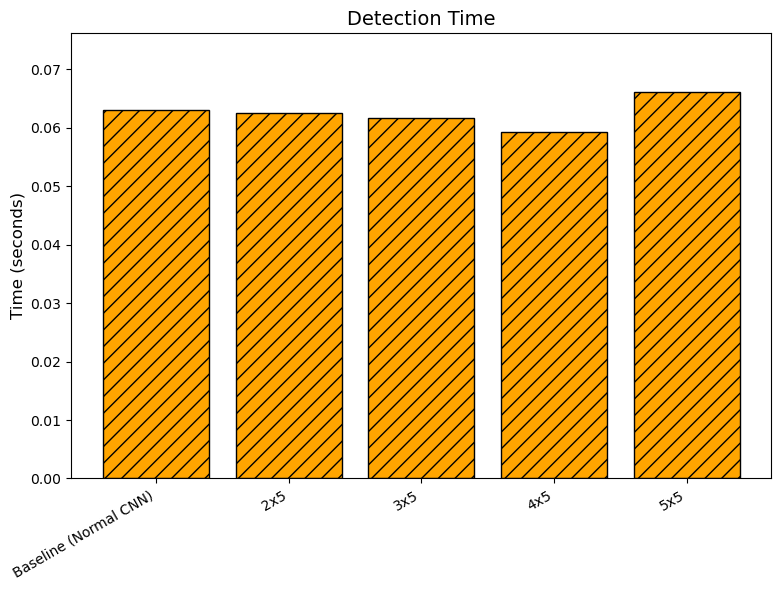

In [29]:
import matplotlib.pyplot as plt
import numpy as np

methods_with_baseline = [
    "Baseline (Normal CNN)", 
    "2x5", 
    "3x5", 
    "4x5", 
    "5x5"
]

detection_time_with_baseline = [0.063013, 0.062527, 0.061705, 0.059348, 0.066182]

x_with_baseline = np.arange(len(methods_with_baseline))

fig, ax = plt.subplots(figsize=(8, 6))

ax.bar(x_with_baseline, detection_time_with_baseline, color="orange", edgecolor="black", hatch="//", align="center")
ax.set_xticks(x_with_baseline)
ax.set_xticklabels(methods_with_baseline, rotation=30, ha="right", fontsize=10)
ax.set_ylim(0, max(detection_time_with_baseline) + 0.01)
ax.set_ylabel("Time (seconds)", fontsize=12)
ax.set_title("Detection Time", fontsize=14)

plt.tight_layout()
plt.show()

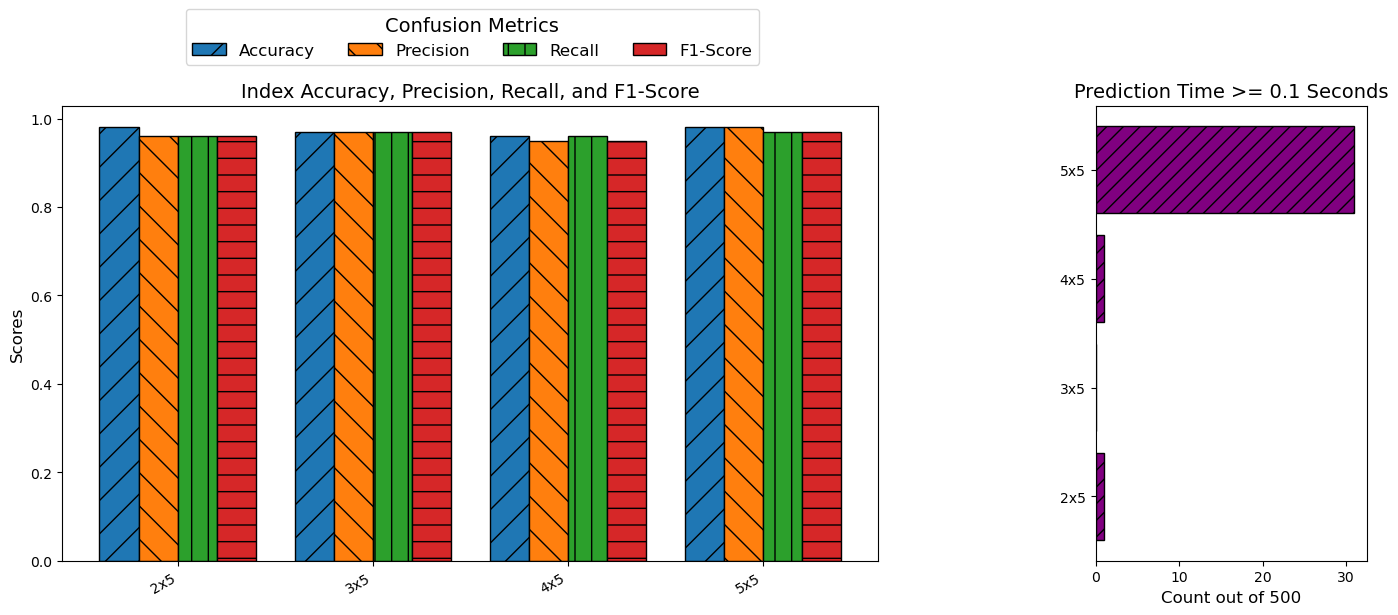

In [1]:
import matplotlib.pyplot as plt
import numpy as np

methods_selected = [
    "2x5", 
    "3x5", 
    "4x5", 
    "5x5"
]

accuracy_selected = [0.98, 0.97, 0.96, 0.98]
precision_selected = [0.96, 0.97, 0.95, 0.98]
recall_selected = [0.96, 0.97, 0.96, 0.97]
f1_score_selected = [0.96, 0.97, 0.95, 0.97]
prediction_time_over_0_1_selected = [1, 0, 1, 31]

x_selected = np.arange(len(methods_selected))
width = 0.2

hatches = ['/', '\\', '|', '-']

fig, ax = plt.subplots(1, 2, figsize=(15, 7), gridspec_kw={'width_ratios': [3, 1]})

ax[0].bar(x_selected - 1.5 * width, accuracy_selected, width, label="Accuracy", hatch=hatches[0], edgecolor='black')
ax[0].bar(x_selected - 0.5 * width, precision_selected, width, label="Precision", hatch=hatches[1], edgecolor='black')
ax[0].bar(x_selected + 0.5 * width, recall_selected, width, label="Recall", hatch=hatches[2], edgecolor='black')
ax[0].bar(x_selected + 1.5 * width, f1_score_selected, width, label="F1-Score", hatch=hatches[3], edgecolor='black')
ax[0].set_xticks(x_selected)
ax[0].set_xticklabels(methods_selected, rotation=30, ha="right", fontsize=10)
ax[0].set_ylabel("Scores", fontsize=12)
ax[0].set_title("Index Accuracy, Precision, Recall, and F1-Score", fontsize=14)

ax[1].barh(x_selected, prediction_time_over_0_1_selected, color="purple", edgecolor="black", hatch="//", align="center")
ax[1].set_yticks(x_selected)
ax[1].set_yticklabels(methods_selected, fontsize=10)
ax[1].set_xlabel("Count out of 500", fontsize=12)
ax[1].set_title("Prediction Time >= 0.1 Seconds", fontsize=14)

fig.legend(
    loc="upper right", 
    bbox_to_anchor=(0.55, 1.0), 
    ncol=4, 
    fontsize=12, 
    title="Confusion Metrics", 
    title_fontsize=14
)

plt.subplots_adjust(left=0.08, right=0.95, top=0.85, bottom=0.2, wspace=0.4)

plt.show()

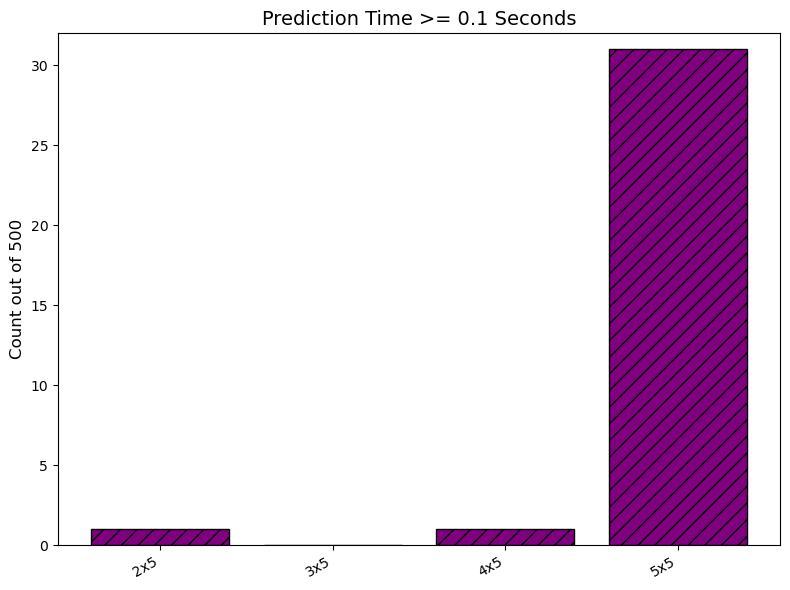

In [31]:
import matplotlib.pyplot as plt
import numpy as np

methods_selected = [
    "2x5", 
    "3x5", 
    "4x5", 
    "5x5"
]

prediction_time_over_0_1_selected = [1, 0, 1, 31]

x_selected = np.arange(len(methods_selected))

fig, ax = plt.subplots(figsize=(8, 6))

ax.bar(x_selected, prediction_time_over_0_1_selected, color="purple", edgecolor="black", hatch="//", align="center")
ax.set_xticks(x_selected)
ax.set_xticklabels(methods_selected, rotation=30, ha="right", fontsize=10)
ax.set_ylim(0, max(prediction_time_over_0_1_selected) + 1)
ax.set_ylabel("Count out of 500", fontsize=12)
ax.set_title("Prediction Time >= 0.1 Seconds", fontsize=14)

plt.tight_layout()
plt.show()

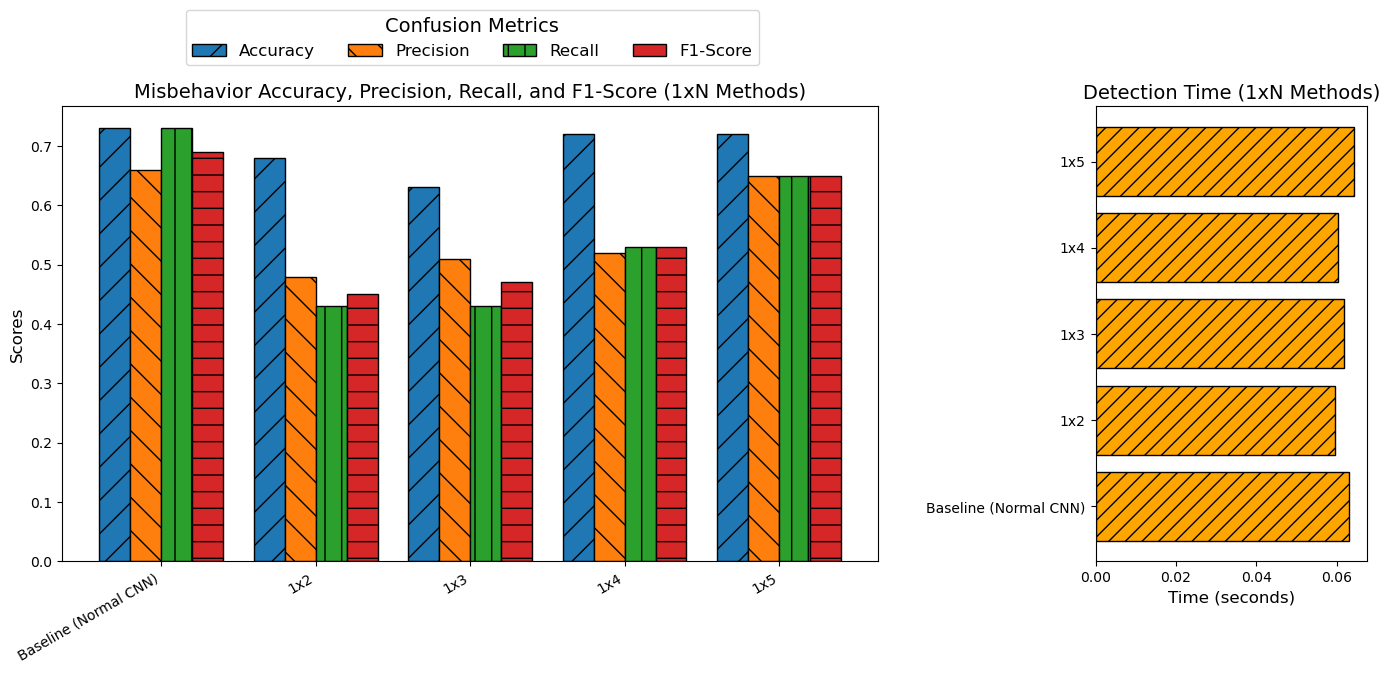

In [32]:
import matplotlib.pyplot as plt
import numpy as np

methods_selected = [
    "Baseline (Normal CNN)", 
    "1x2", 
    "1x3", 
    "1x4", 
    "1x5"
]

accuracy_selected = [0.73, 0.68, 0.63, 0.72, 0.72]
precision_selected = [0.66, 0.48, 0.51, 0.52, 0.65]
recall_selected = [0.73, 0.43, 0.43, 0.53, 0.65]
f1_score_selected = [0.69, 0.45, 0.47, 0.53, 0.65]
detection_time_selected = [0.063013, 0.059394, 0.061628, 0.060277, 0.064344]

x_selected = np.arange(len(methods_selected))
width = 0.2

hatches = ['/', '\\', '|', '-']

fig, ax = plt.subplots(1, 2, figsize=(15, 7), gridspec_kw={'width_ratios': [3, 1]})

ax[0].bar(x_selected - 1.5 * width, accuracy_selected, width, label="Accuracy", hatch=hatches[0], edgecolor='black')
ax[0].bar(x_selected - 0.5 * width, precision_selected, width, label="Precision", hatch=hatches[1], edgecolor='black')
ax[0].bar(x_selected + 0.5 * width, recall_selected, width, label="Recall", hatch=hatches[2], edgecolor='black')
ax[0].bar(x_selected + 1.5 * width, f1_score_selected, width, label="F1-Score", hatch=hatches[3], edgecolor='black')
ax[0].set_xticks(x_selected)
ax[0].set_xticklabels(methods_selected, rotation=30, ha="right", fontsize=10)
ax[0].set_ylabel("Scores", fontsize=12)
ax[0].set_title("Misbehavior Accuracy, Precision, Recall, and F1-Score (1xN Methods)", fontsize=14)

ax[1].barh(x_selected, detection_time_selected, color="orange", edgecolor="black", hatch="//", align="center")
ax[1].set_yticks(x_selected)
ax[1].set_yticklabels(methods_selected, fontsize=10)
ax[1].set_xlabel("Time (seconds)", fontsize=12)
ax[1].set_title("Detection Time (1xN Methods)", fontsize=14)

fig.legend(
    loc="upper right", 
    bbox_to_anchor=(0.55, 1.0), 
    ncol=4, 
    fontsize=12, 
    title="Confusion Metrics", 
    title_fontsize=14
)

plt.subplots_adjust(left=0.08, right=0.95, top=0.85, bottom=0.2, wspace=0.4)

plt.show()

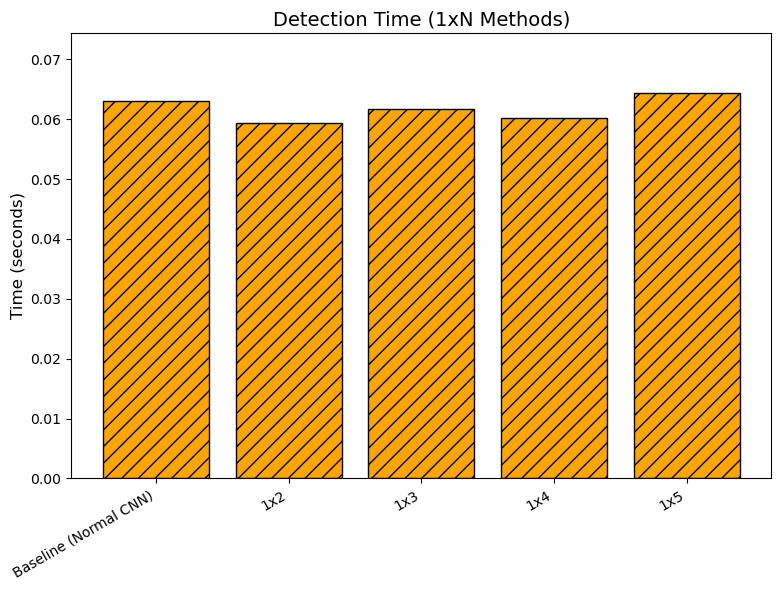

In [33]:
import matplotlib.pyplot as plt
import numpy as np

methods_selected = [
    "Baseline (Normal CNN)", 
    "1x2", 
    "1x3", 
    "1x4", 
    "1x5"
]

detection_time_selected = [0.063013, 0.059394, 0.061628, 0.060277, 0.064344]

x_selected = np.arange(len(methods_selected))

fig, ax = plt.subplots(figsize=(8, 6))

ax.bar(x_selected, detection_time_selected, color="orange", edgecolor="black", hatch="//", align="center")
ax.set_xticks(x_selected)
ax.set_xticklabels(methods_selected, rotation=30, ha="right", fontsize=10)
ax.set_ylim(0, max(detection_time_selected) + 0.01)
ax.set_ylabel("Time (seconds)", fontsize=12)
ax.set_title("Detection Time (1xN Methods)", fontsize=14)

plt.tight_layout()
plt.show()

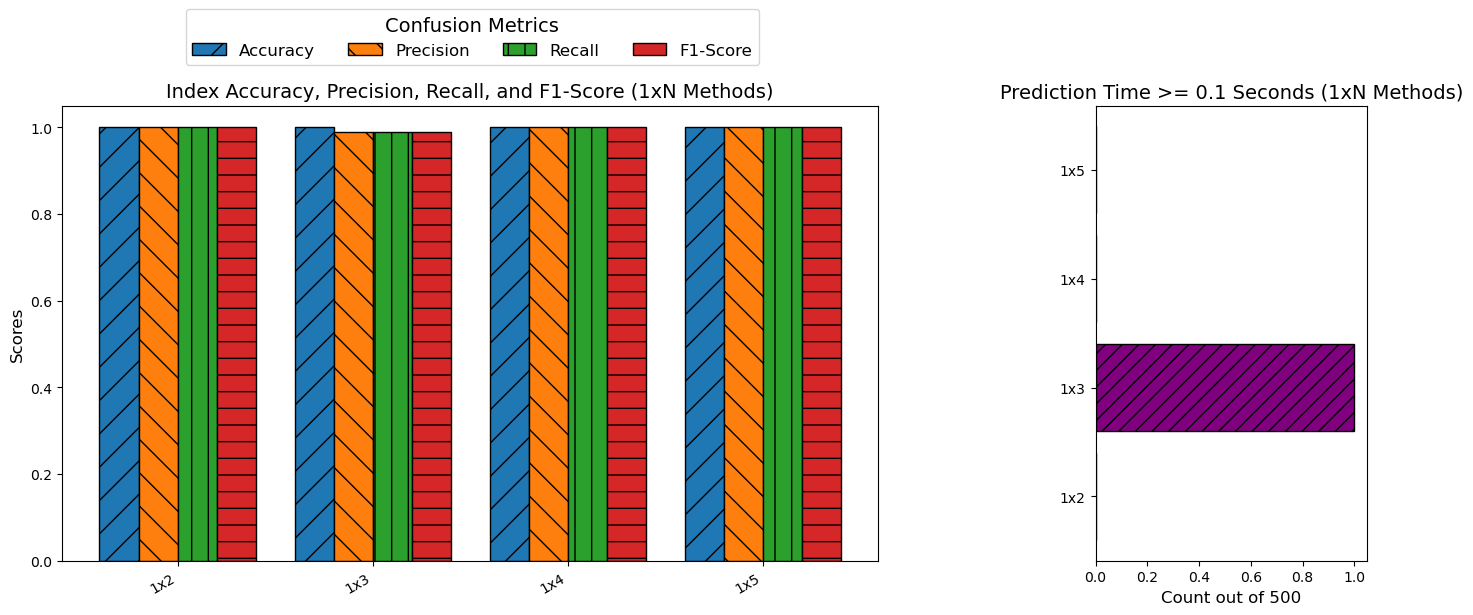

In [34]:
import matplotlib.pyplot as plt
import numpy as np

methods_selected = [
    "1x2", 
    "1x3", 
    "1x4", 
    "1x5"
]

accuracy_selected = [1.00, 1.00, 1.00, 1.00]
precision_selected = [1.00, 0.99, 1.00, 1.00]
recall_selected = [1.00, 0.99, 1.00, 1.00]
f1_score_selected = [1.00, 0.99, 1.00, 1.00]
prediction_time_selected = [0, 1, 0, 0]  # Out of 500

x_selected = np.arange(len(methods_selected))
width = 0.2

hatches = ['/', '\\', '|', '-']

fig, ax = plt.subplots(1, 2, figsize=(15, 7), gridspec_kw={'width_ratios': [3, 1]})

ax[0].bar(x_selected - 1.5 * width, accuracy_selected, width, label="Accuracy", hatch=hatches[0], edgecolor='black')
ax[0].bar(x_selected - 0.5 * width, precision_selected, width, label="Precision", hatch=hatches[1], edgecolor='black')
ax[0].bar(x_selected + 0.5 * width, recall_selected, width, label="Recall", hatch=hatches[2], edgecolor='black')
ax[0].bar(x_selected + 1.5 * width, f1_score_selected, width, label="F1-Score", hatch=hatches[3], edgecolor='black')
ax[0].set_xticks(x_selected)
ax[0].set_xticklabels(methods_selected, rotation=30, ha="right", fontsize=10)
ax[0].set_ylabel("Scores", fontsize=12)
ax[0].set_title("Index Accuracy, Precision, Recall, and F1-Score (1xN Methods)", fontsize=14)

ax[1].barh(x_selected, prediction_time_selected, color="purple", edgecolor="black", hatch="//", align="center")
ax[1].set_yticks(x_selected)
ax[1].set_yticklabels(methods_selected, fontsize=10)
ax[1].set_xlabel("Count out of 500", fontsize=12)
ax[1].set_title("Prediction Time >= 0.1 Seconds (1xN Methods)", fontsize=14)

fig.legend(
    loc="upper right", 
    bbox_to_anchor=(0.55, 1.0), 
    ncol=4, 
    fontsize=12, 
    title="Confusion Metrics", 
    title_fontsize=14
)

plt.subplots_adjust(left=0.08, right=0.95, top=0.85, bottom=0.2, wspace=0.4)

plt.show()

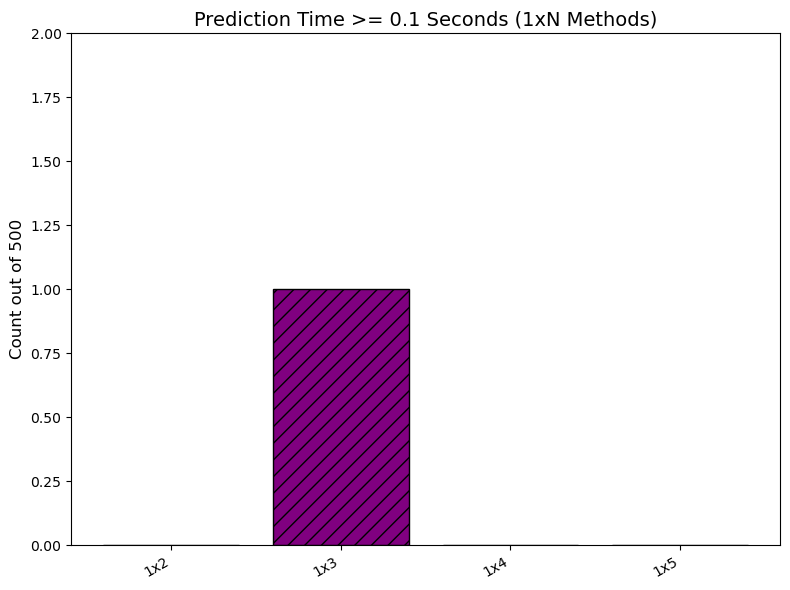

In [35]:
import matplotlib.pyplot as plt
import numpy as np

methods_selected = [
    "1x2", 
    "1x3", 
    "1x4", 
    "1x5"
]

prediction_time_selected = [0, 1, 0, 0]  # Out of 500

x_selected = np.arange(len(methods_selected))

fig, ax = plt.subplots(figsize=(8, 6))

ax.bar(x_selected, prediction_time_selected, color="purple", edgecolor="black", hatch="//", align="center")
ax.set_xticks(x_selected)
ax.set_xticklabels(methods_selected, rotation=30, ha="right", fontsize=10)
ax.set_ylim(0, max(prediction_time_selected) + 1)
ax.set_ylabel("Count out of 500", fontsize=12)
ax.set_title("Prediction Time >= 0.1 Seconds (1xN Methods)", fontsize=14)

plt.tight_layout()
plt.show()

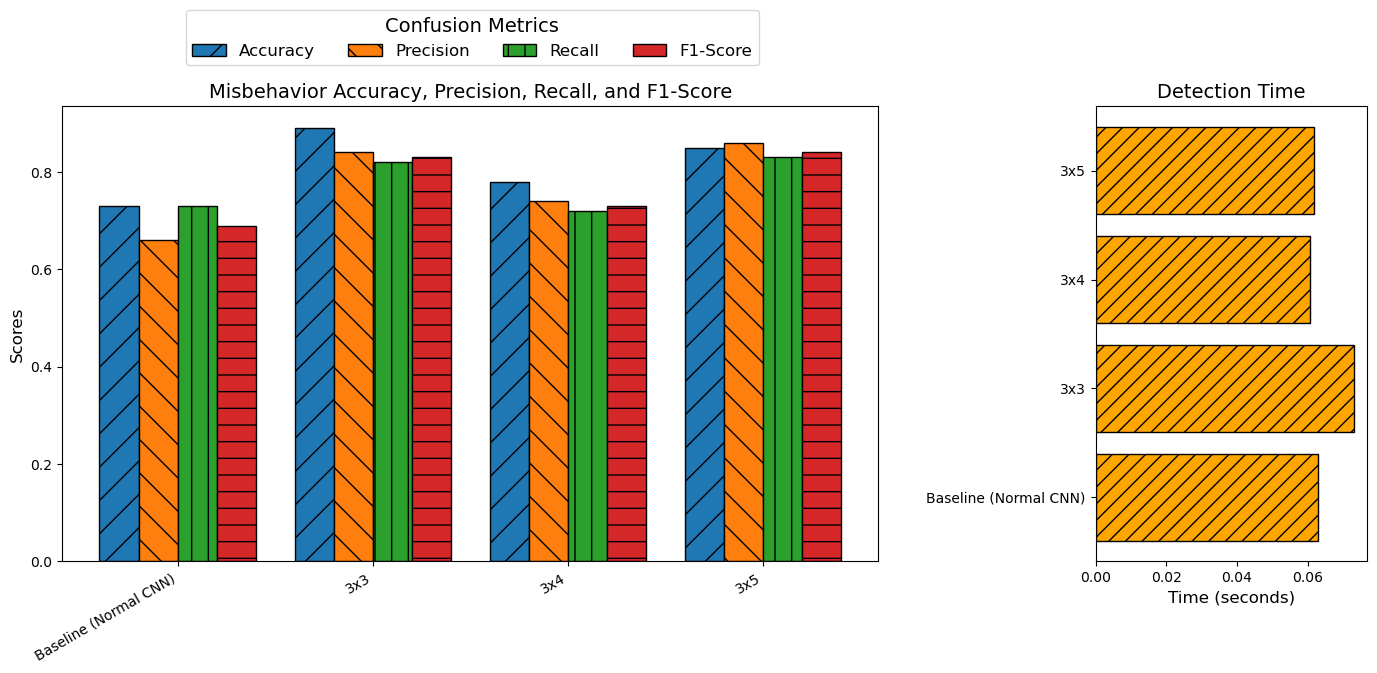

In [64]:
import matplotlib.pyplot as plt
import numpy as np

methods_with_baseline = [
    "Baseline (Normal CNN)", 
    "3x3", 
    "3x4", 
    "3x5"
]

accuracy_with_baseline = [0.73, 0.89, 0.78, 0.85]
precision_with_baseline = [0.66, 0.84, 0.74, 0.86]
recall_with_baseline = [0.73, 0.82, 0.72, 0.83]
f1_score_with_baseline = [0.69, 0.83, 0.73, 0.84]
detection_time_with_baseline = [0.063013, 0.073272, 0.060779, 0.061705]

x_with_baseline = np.arange(len(methods_with_baseline))
width = 0.2

hatches = ['/', '\\', '|', '-']

fig, ax = plt.subplots(1, 2, figsize=(15, 7), gridspec_kw={'width_ratios': [3, 1]})

ax[0].bar(x_with_baseline - 1.5 * width, accuracy_with_baseline, width, label="Accuracy", hatch=hatches[0], edgecolor='black')
ax[0].bar(x_with_baseline - 0.5 * width, precision_with_baseline, width, label="Precision", hatch=hatches[1], edgecolor='black')
ax[0].bar(x_with_baseline + 0.5 * width, recall_with_baseline, width, label="Recall", hatch=hatches[2], edgecolor='black')
ax[0].bar(x_with_baseline + 1.5 * width, f1_score_with_baseline, width, label="F1-Score", hatch=hatches[3], edgecolor='black')
ax[0].set_xticks(x_with_baseline)
ax[0].set_xticklabels(methods_with_baseline, rotation=30, ha="right", fontsize=10)
ax[0].set_ylabel("Scores", fontsize=12)
ax[0].set_title("Misbehavior Accuracy, Precision, Recall, and F1-Score", fontsize=14)

ax[1].barh(x_with_baseline, detection_time_with_baseline, color="orange", edgecolor="black", hatch="//", align="center")
ax[1].set_yticks(x_with_baseline)
ax[1].set_yticklabels(methods_with_baseline, fontsize=10)
ax[1].set_xlabel("Time (seconds)", fontsize=12)
ax[1].set_title("Detection Time", fontsize=14)

fig.legend(
    loc="upper right", 
    bbox_to_anchor=(0.55, 1.0), 
    ncol=4, 
    fontsize=12, 
    title="Confusion Metrics", 
    title_fontsize=14
)

plt.subplots_adjust(left=0.08, right=0.95, top=0.85, bottom=0.2, wspace=0.4)

plt.show()

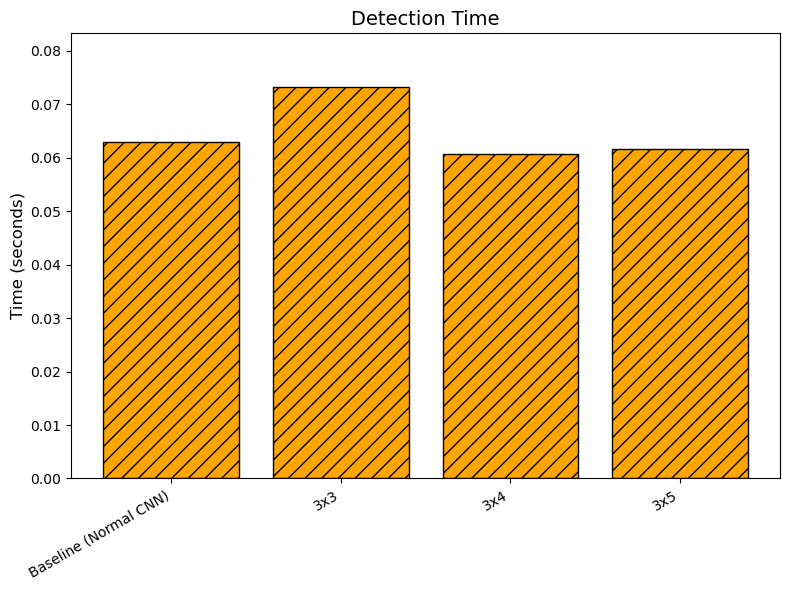

In [43]:
import matplotlib.pyplot as plt
import numpy as np

methods_with_baseline = [
    "Baseline (Normal CNN)", 
    "3x3", 
    "3x4", 
    "3x5"
]

detection_time_with_baseline = [0.063013, 0.073272, 0.060779, 0.061705]

x_with_baseline = np.arange(len(methods_with_baseline))

fig, ax = plt.subplots(figsize=(8, 6))

ax.bar(x_with_baseline, detection_time_with_baseline, color="orange", edgecolor="black", hatch="//", align="center")
ax.set_xticks(x_with_baseline)
ax.set_xticklabels(methods_with_baseline, rotation=30, ha="right", fontsize=10)
ax.set_ylim(0, max(detection_time_with_baseline) + 0.01)
ax.set_ylabel("Time (seconds)", fontsize=12)
ax.set_title("Detection Time", fontsize=14)

plt.tight_layout()
plt.show()

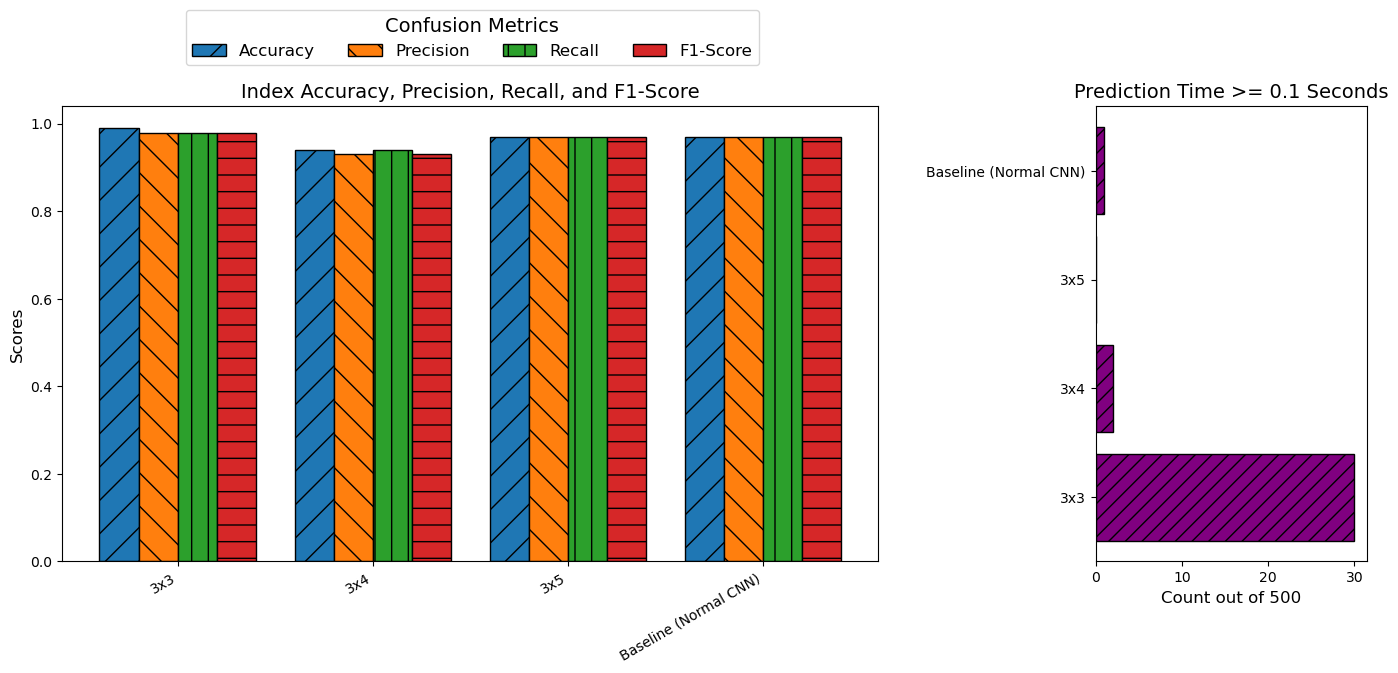

In [45]:
import matplotlib.pyplot as plt
import numpy as np

methods_with_baseline = [
    "3x3", 
    "3x4", 
    "3x5", 
    "Baseline (Normal CNN)"
]

accuracy_selected = [0.99, 0.94, 0.97, 0.97]
precision_selected = [0.98, 0.93, 0.97, 0.97]
recall_selected = [0.98, 0.94, 0.97, 0.97]
f1_score_selected = [0.98, 0.93, 0.97, 0.97]
prediction_time_over_0_1_selected = [30, 2, 0, 1]

x_with_baseline = np.arange(len(methods_with_baseline))
width = 0.2

hatches = ['/', '\\', '|', '-']

fig, ax = plt.subplots(1, 2, figsize=(15, 7), gridspec_kw={'width_ratios': [3, 1]})

ax[0].bar(x_with_baseline - 1.5 * width, accuracy_selected, width, label="Accuracy", hatch=hatches[0], edgecolor='black')
ax[0].bar(x_with_baseline - 0.5 * width, precision_selected, width, label="Precision", hatch=hatches[1], edgecolor='black')
ax[0].bar(x_with_baseline + 0.5 * width, recall_selected, width, label="Recall", hatch=hatches[2], edgecolor='black')
ax[0].bar(x_with_baseline + 1.5 * width, f1_score_selected, width, label="F1-Score", hatch=hatches[3], edgecolor='black')
ax[0].set_xticks(x_with_baseline)
ax[0].set_xticklabels(methods_with_baseline, rotation=30, ha="right", fontsize=10)
ax[0].set_ylabel("Scores", fontsize=12)
ax[0].set_title("Index Accuracy, Precision, Recall, and F1-Score", fontsize=14)

ax[1].barh(x_with_baseline, prediction_time_over_0_1_selected, color="purple", edgecolor="black", hatch="//", align="center")
ax[1].set_yticks(x_with_baseline)
ax[1].set_yticklabels(methods_with_baseline, fontsize=10)
ax[1].set_xlabel("Count out of 500", fontsize=12)
ax[1].set_title("Prediction Time >= 0.1 Seconds", fontsize=14)

fig.legend(
    loc="upper right", 
    bbox_to_anchor=(0.55, 1.0), 
    ncol=4, 
    fontsize=12, 
    title="Confusion Metrics", 
    title_fontsize=14
)

plt.subplots_adjust(left=0.08, right=0.95, top=0.85, bottom=0.2, wspace=0.4)

plt.show()

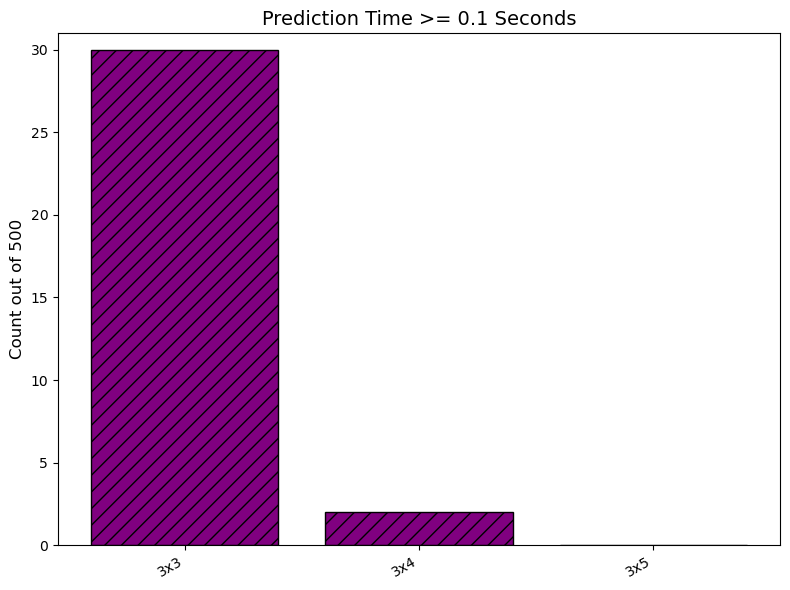

In [63]:
import matplotlib.pyplot as plt
import numpy as np

methods_with_baseline = [
    "3x3", 
    "3x4", 
    "3x5"
]

prediction_time_over_0_1_selected = [30, 2, 0]

x_with_baseline = np.arange(len(methods_with_baseline))

fig, ax = plt.subplots(figsize=(8, 6))

ax.bar(x_with_baseline, prediction_time_over_0_1_selected, color="purple", edgecolor="black", hatch="//", align="center")
ax.set_xticks(x_with_baseline)
ax.set_xticklabels(methods_with_baseline, rotation=30, ha="right", fontsize=10)
ax.set_ylim(0, max(prediction_time_over_0_1_selected) + 1)
ax.set_ylabel("Count out of 500", fontsize=12)
ax.set_title("Prediction Time >= 0.1 Seconds", fontsize=14)

plt.tight_layout()
plt.show()

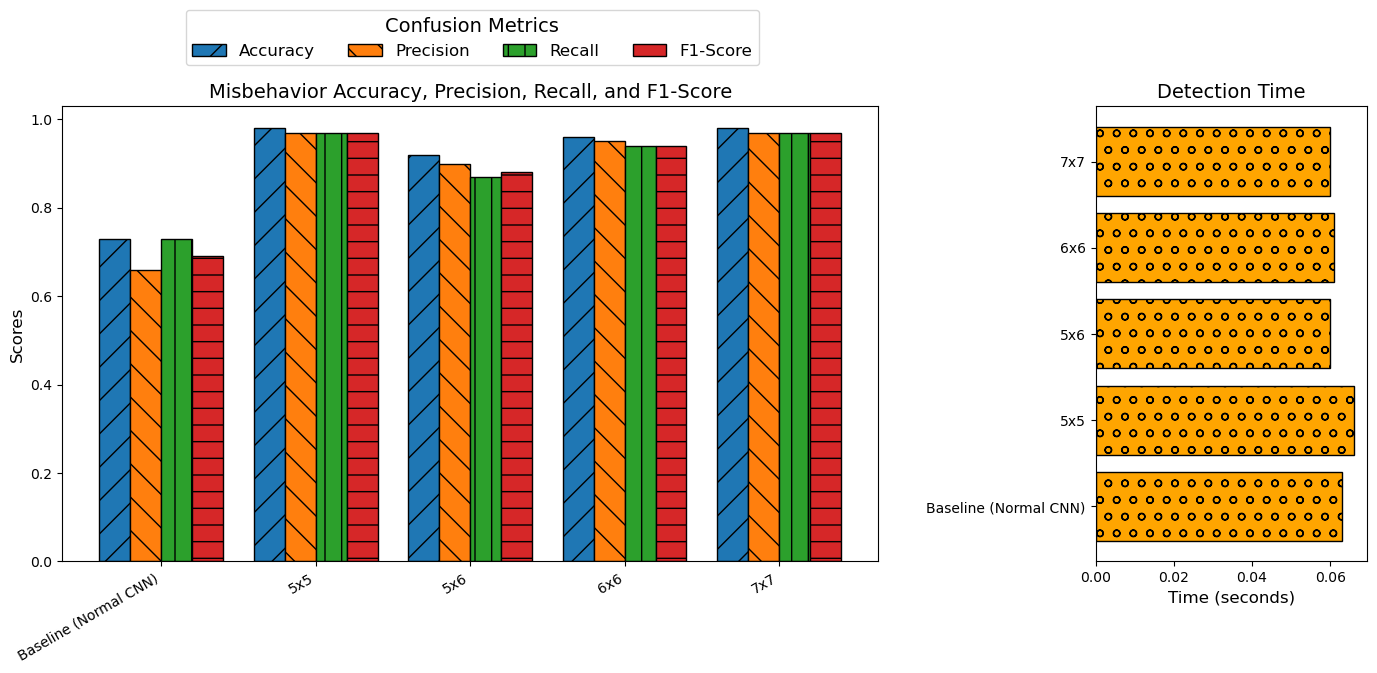

In [2]:
import matplotlib.pyplot as plt
import numpy as np

methods_with_baseline = [
    "Baseline (Normal CNN)", 
    "5x5", 
    "5x6", 
    "6x6", 
    "7x7"
]

accuracy_selected = [0.73, 0.98, 0.92, 0.96, 0.98]
precision_selected = [0.66, 0.97, 0.90, 0.95, 0.97]
recall_selected = [0.73, 0.97, 0.87, 0.94, 0.97]
f1_score_selected = [0.69, 0.97, 0.88, 0.94, 0.97]
detection_time_selected = [0.063013, 0.066182, 0.059815, 0.060963, 0.059908]

x_with_baseline = np.arange(len(methods_with_baseline))
width = 0.2

hatches = ['/', '\\', '|', '-', 'o']

fig, ax = plt.subplots(1, 2, figsize=(15, 7), gridspec_kw={'width_ratios': [3, 1]})

ax[0].bar(x_with_baseline - 1.5 * width, accuracy_selected, width, label="Accuracy", hatch=hatches[0], edgecolor='black')
ax[0].bar(x_with_baseline - 0.5 * width, precision_selected, width, label="Precision", hatch=hatches[1], edgecolor='black')
ax[0].bar(x_with_baseline + 0.5 * width, recall_selected, width, label="Recall", hatch=hatches[2], edgecolor='black')
ax[0].bar(x_with_baseline + 1.5 * width, f1_score_selected, width, label="F1-Score", hatch=hatches[3], edgecolor='black')
ax[0].set_xticks(x_with_baseline)
ax[0].set_xticklabels(methods_with_baseline, rotation=30, ha="right", fontsize=10)
ax[0].set_ylabel("Scores", fontsize=12)
ax[0].set_title("Misbehavior Accuracy, Precision, Recall, and F1-Score", fontsize=14)

ax[1].barh(x_with_baseline, detection_time_selected, color="orange", edgecolor="black", hatch=hatches[4], align="center")
ax[1].set_yticks(x_with_baseline)
ax[1].set_yticklabels(methods_with_baseline, fontsize=10)
ax[1].set_xlabel("Time (seconds)", fontsize=12)
ax[1].set_title("Detection Time", fontsize=14)

fig.legend(
    loc="upper right", 
    bbox_to_anchor=(0.55, 1.0), 
    ncol=4, 
    fontsize=12, 
    title="Confusion Metrics", 
    title_fontsize=14
)

plt.subplots_adjust(left=0.08, right=0.95, top=0.85, bottom=0.2, wspace=0.4)

plt.show()

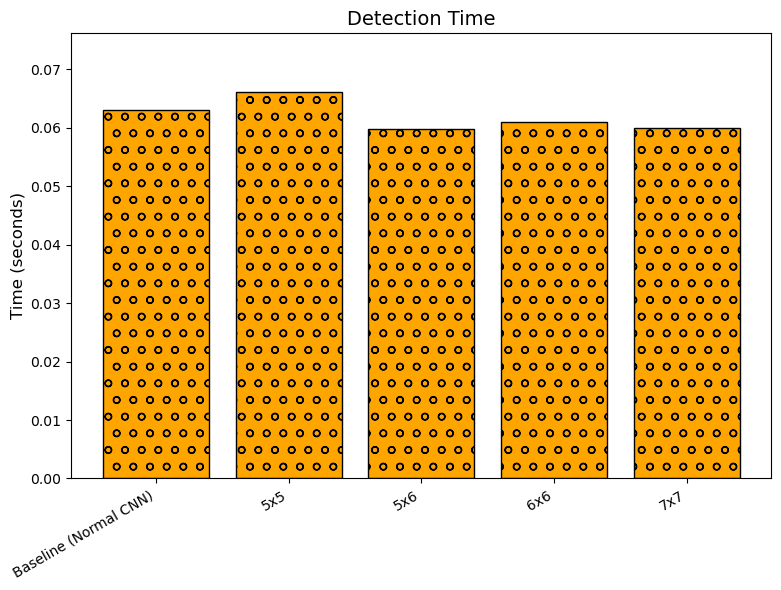

In [46]:
import matplotlib.pyplot as plt
import numpy as np

methods_with_baseline = [
    "Baseline (Normal CNN)", 
    "5x5", 
    "5x6", 
    "6x6",
    "7x7"
]

detection_time_selected = [0.063013, 0.066182, 0.059815, 0.060963, 0.059908]

x_with_baseline = np.arange(len(methods_with_baseline))
hatch = 'o'

fig, ax = plt.subplots(figsize=(8, 6))

ax.bar(x_with_baseline, detection_time_selected, color="orange", edgecolor="black", hatch=hatch, align="center")
ax.set_xticks(x_with_baseline)
ax.set_xticklabels(methods_with_baseline, rotation=30, ha="right", fontsize=10)
ax.set_ylim(0, max(detection_time_selected) + 0.01)
ax.set_ylabel("Time (seconds)", fontsize=12)
ax.set_title("Detection Time", fontsize=14)

plt.tight_layout()
plt.show()

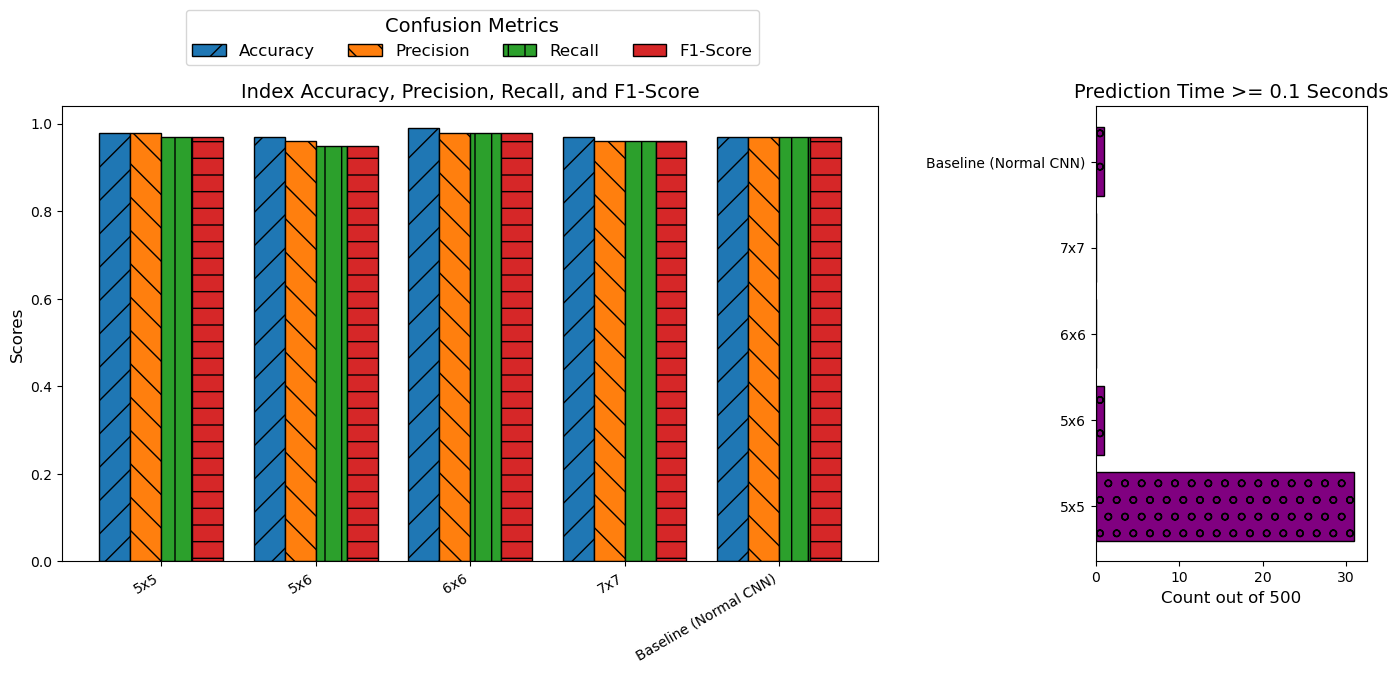

In [49]:
import matplotlib.pyplot as plt
import numpy as np

methods_selected = [
    "5x5", 
    "5x6", 
    "6x6", 
    "7x7", 
    "Baseline (Normal CNN)"
]

accuracy_selected = [0.98, 0.97, 0.99, 0.97, 0.97]
precision_selected = [0.98, 0.96, 0.98, 0.96, 0.97]
recall_selected = [0.97, 0.95, 0.98, 0.96, 0.97]
f1_score_selected = [0.97, 0.95, 0.98, 0.96, 0.97]
prediction_time_over_0_1_selected = [31, 1, 0, 0, 1]

x_selected = np.arange(len(methods_selected))
width = 0.2

hatches = ['/', '\\', '|', '-', 'o']

fig, ax = plt.subplots(1, 2, figsize=(15, 7), gridspec_kw={'width_ratios': [3, 1]})

ax[0].bar(x_selected - 1.5 * width, accuracy_selected, width, label="Accuracy", hatch=hatches[0], edgecolor='black')
ax[0].bar(x_selected - 0.5 * width, precision_selected, width, label="Precision", hatch=hatches[1], edgecolor='black')
ax[0].bar(x_selected + 0.5 * width, recall_selected, width, label="Recall", hatch=hatches[2], edgecolor='black')
ax[0].bar(x_selected + 1.5 * width, f1_score_selected, width, label="F1-Score", hatch=hatches[3], edgecolor='black')
ax[0].set_xticks(x_selected)
ax[0].set_xticklabels(methods_selected, rotation=30, ha="right", fontsize=10)
ax[0].set_ylabel("Scores", fontsize=12)
ax[0].set_title("Index Accuracy, Precision, Recall, and F1-Score", fontsize=14)

ax[1].barh(x_selected, prediction_time_over_0_1_selected, color="purple", edgecolor="black", hatch=hatches[4], align="center")
ax[1].set_yticks(x_selected)
ax[1].set_yticklabels(methods_selected, fontsize=10)
ax[1].set_xlabel("Count out of 500", fontsize=12)
ax[1].set_title("Prediction Time >= 0.1 Seconds", fontsize=14)

fig.legend(
    loc="upper right", 
    bbox_to_anchor=(0.55, 1.0), 
    ncol=4, 
    fontsize=12, 
    title="Confusion Metrics", 
    title_fontsize=14
)

plt.subplots_adjust(left=0.08, right=0.95, top=0.85, bottom=0.2, wspace=0.4)

plt.show()

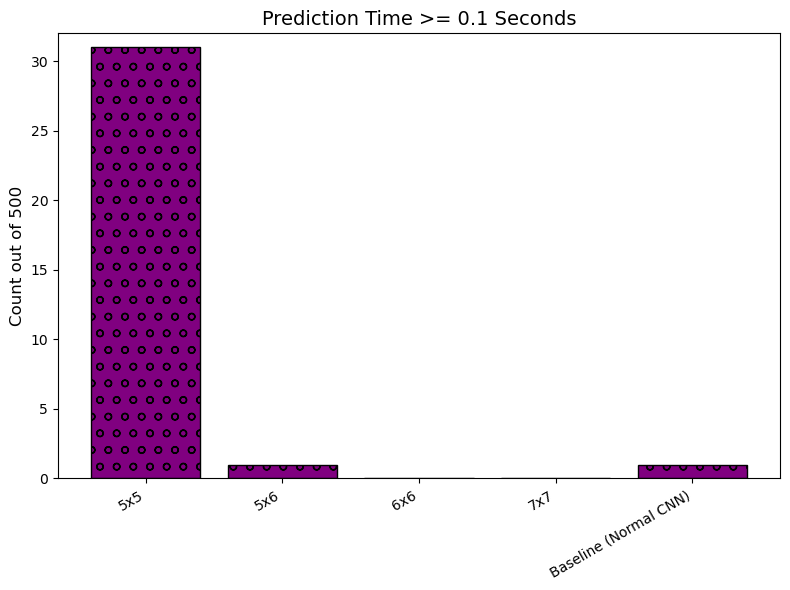

In [50]:
import matplotlib.pyplot as plt
import numpy as np

methods_selected = [
    "5x5", 
    "5x6", 
    "6x6", 
    "7x7", 
    "Baseline (Normal CNN)"
]

prediction_time_over_0_1_selected = [31, 1, 0, 0, 1]

x_selected = np.arange(len(methods_selected))
hatch = 'o'

fig, ax = plt.subplots(figsize=(8, 6))

ax.bar(x_selected, prediction_time_over_0_1_selected, color="purple", edgecolor="black", hatch=hatch, align="center")
ax.set_xticks(x_selected)
ax.set_xticklabels(methods_selected, rotation=30, ha="right", fontsize=10)
ax.set_ylim(0, max(prediction_time_over_0_1_selected) + 1)
ax.set_ylabel("Count out of 500", fontsize=12)
ax.set_title("Prediction Time >= 0.1 Seconds", fontsize=14)

plt.tight_layout()
plt.show()

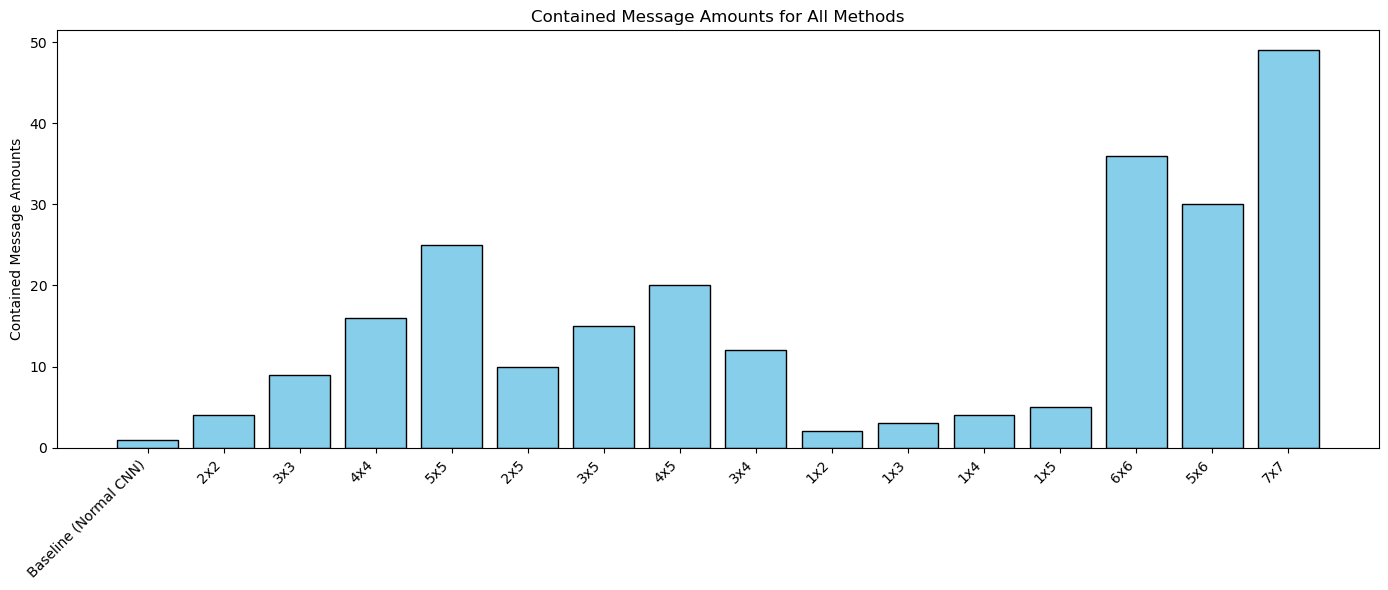

In [52]:
methods_updated = [
    "Baseline (Normal CNN)", "2x2", "3x3",
    "4x4", "5x5", "2x5",
    "3x5", "4x5", "3x4",
    "1x2", "1x3", "1x4",
    "1x5", "6x6", "5x6",
    "7x7"
]

message_amounts_updated = [
    1, 4, 9, 16, 25, 10, 15, 20, 12, 2, 3, 4, 5, 36, 30, 49
]

x_updated = np.arange(len(methods_updated))

plt.figure(figsize=(14, 6))
plt.bar(x_updated, message_amounts_updated, color="skyblue", edgecolor="black", align="center")
plt.xticks(x_updated, methods_updated, rotation=45, ha="right")
plt.ylabel("Contained Message Amounts")
plt.title("Contained Message Amounts for All Methods")
plt.tight_layout()
plt.show()